<a href="https://colab.research.google.com/github/Marcin19721205/BasicTrainingPython/blob/main/_WSB_ProjektSieciNeuronowejMNIST_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DANE MNIST

* Grupa projektowa: Marcin Jabłoński / Marta Niebrzegowska

* Problem klasyfikacyjny - biblioteka MNIST

### Spis treści:
1. [Import bibliotek](#0)
2. [Zbiór danych MNIST](#1)
3. [Standaryzacja](#2)
4. [Augmentacja](#4)
6. [Spłaszczenie do modeli ML](#5)
7. [Wariancja skumulowana PCA](#6)
8. [Model PCA dla n=256](#7)
9. [Model Regresji Logistycznej - inicjalizacyjny](#8)
10. [Model SVC - inicjalizacyjny](#9)
11. [Przygotowanie wycinka danych do tuningu RL/SVC](#10)
12. [Tuner — Logistic Regression (PCA=256) - 9 fitów](#11)
13. [Tuner — SVC (LinearSVC, bo klasyczny SVC z RBF na 50k za wolno) - 9 fits](#12)
14. [Regresja Logistyczna - na najlepszych parametrach](#13)
15. [SVC - Na najlepszych parametrach](#14)
16. [Podsumowanie Regresji Logistycznej (Init / best param) + SVC (Initial/ best param) ](#15)
17. [Siec neuronowa CNN first guess) ](#16)
18. [Trening sieci na danych wejściowych bez spłaszczania](#17)
19. [Podsumowanie sieci - inicjal parameters](#18)
20. [Tuner 1 (liczba bloków konwolucji i funkcja aktywacji)](#19)
21. [Tuner 1 trening na best parameters](#20)
22. [Tuner 2 - zmienia funkcje aktywacji / szer filtru / dropout / L2 reg, ilość neuronow i regularyzacje](#21)
23. [Tuner 2 trening na best parameters](#22)
24. [Tuner 2 model z walidacją krzyżową](#23)
25. [Podsumowanie wszystkich Modeli ](#24)
26. [xxxx](#25)
27. [xxxx](#26)
28. [xxxx](#27)
29. [xxxx](#28)
30. [xxxx](#29)
31. [xxxx](#30)





### <a name='0'></a> 1. Import bibliotek

In [ ]:
#Import wymaganych bibliotek

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

np.set_printoptions(precision=4, suppress=True, linewidth=150)

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.decomposition import PCA

import plotly.graph_objects as go
from keras.datasets import mnist

### <a name='1'></a> 2. Zbiór danych MNIST

In [ ]:
from tensorflow.keras.datasets import mnist

# MNIST: wczytanie danych
(mnist_X_train_raw, mnist_y_train_raw), (mnist_X_test_raw, mnist_y_test_raw) = mnist.load_data()

print("mnist_X_train_raw:", mnist_X_train_raw.shape)
print("mnist_y_train_raw:", mnist_y_train_raw.shape)
print("mnist_X_test_raw:",  mnist_X_test_raw.shape)
print("mnist_y_test_raw:",  mnist_y_test_raw.shape)

# spłaszczenie etykiet do wektora 1D (dla spójności; MNIST zwykle już jest (N,))
mnist_y_train = mnist_y_train_raw.reshape(-1)
mnist_y_test  = mnist_y_test_raw.reshape(-1)

print("mnist_y_train (after reshape):", mnist_y_train.shape)
print("mnist_y_test  (after reshape):", mnist_y_test.shape)

# etykiety do klasyfikacji (1D int) — jedna nazwa na cały projekt
mnist_y_train_cls = mnist_y_train.astype(np.int64)
mnist_y_test_cls  = mnist_y_test.astype(np.int64)

mnist_X_train_raw: (60000, 28, 28)
mnist_y_train_raw: (60000,)
mnist_X_test_raw: (10000, 28, 28)
mnist_y_test_raw: (10000,)
mnist_y_train (after reshape): (60000,)
mnist_y_test  (after reshape): (10000,)


Statystyka danych, sprawdzenie czy dane są pełne i czy mają odpowiedni typ, liczność klas

In [ ]:
# Statystyka danych X (MNIST)
def mnist_stats_X(name, X):
    Xf = X.astype(np.float32)
    print(f"\n{name}")
    print("  shape:", X.shape, "| dtype:", X.dtype)
    print("  min/max :", float(Xf.min()), float(Xf.max()))
    print("  mean/std:", float(Xf.mean()), float(Xf.std()))
    print("  q01/q50/q99:",
          float(np.quantile(Xf, 0.01)),
          float(np.quantile(Xf, 0.50)),
          float(np.quantile(Xf, 0.99)))
    # per-kanał (dla (N,H,W,1))
    if Xf.ndim == 4 and Xf.shape[-1] == 1:
        ch_mean = Xf.mean(axis=(0,1,2))
        ch_std  = Xf.std(axis=(0,1,2))
        print("  CH mean:", ch_mean)   # 1 wartość
        print("  CH std :", ch_std)    # 1 wartość
    print("  NaN/Inf :", int(np.isnan(Xf).sum()), "/", int(np.isinf(Xf).sum()))

mnist_stats_X("mnist_X_train_raw", mnist_X_train_raw)
mnist_stats_X("mnist_X_test_raw",  mnist_X_test_raw)

# Statystyka y (etykiety) — MNIST
def mnist_stats_y(name, y):
    yv = np.asarray(y).reshape(-1)
    uniq, cnt = np.unique(yv, return_counts=True)
    print(f"\n{name}")
    print("  shape:", yv.shape, "| dtype:", yv.dtype)
    print("  min/max:", int(yv.min()), int(yv.max()))
    print("  counts :", dict(zip(uniq.tolist(), cnt.tolist())))
    print("  props  :", dict(zip(uniq.tolist(), (cnt/len(yv)).round(4).tolist())))

mnist_stats_y("mnist_y_train", mnist_y_train)
mnist_stats_y("mnist_y_test",  mnist_y_test)



mnist_X_train_raw
  shape: (60000, 28, 28) | dtype: uint8
  min/max : 0.0 255.0
  mean/std: 33.31844711303711 78.56744384765625
  q01/q50/q99: 0.0 0.0 254.0
  NaN/Inf : 0 / 0

mnist_X_test_raw
  shape: (10000, 28, 28) | dtype: uint8
  min/max : 0.0 255.0
  mean/std: 33.79124069213867 79.17245483398438
  q01/q50/q99: 0.0 0.0 254.0
  NaN/Inf : 0 / 0

mnist_y_train
  shape: (60000,) | dtype: uint8
  min/max: 0 9
  counts : {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
  props  : {0: 0.0987, 1: 0.1124, 2: 0.0993, 3: 0.1022, 4: 0.0974, 5: 0.0904, 6: 0.0986, 7: 0.1044, 8: 0.0975, 9: 0.0992}

mnist_y_test
  shape: (10000,) | dtype: uint8
  min/max: 0 9
  counts : {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}
  props  : {0: 0.098, 1: 0.1135, 2: 0.1032, 3: 0.101, 4: 0.0982, 5: 0.0892, 6: 0.0958, 7: 0.1028, 8: 0.0974, 9: 0.1009}


^

^

^

Jak widać powyżej klasy są równo rozłożone, dlatego nie potrzeba przeprowadzać równoważenia klas

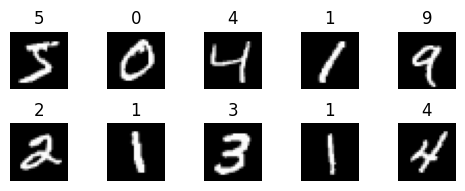

In [ ]:
import matplotlib.pyplot as plt

# szybki podgląd obrazków - pierwsze 10
# MNIST: cyfry 0-9 (10 klas), obraz grayscale 28x28
mnist_class_names = [str(i) for i in range(10)]

plt.figure(figsize=(5, 2))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(mnist_X_train_raw[i], cmap="gray")  # grayscale
    plt.title(mnist_class_names[mnist_y_train[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()


### <a name='2'></a> 3. Standaryzacja

In [ ]:

"""
MNIST: skaluje piksele do [0,1] (float32) i standaryzuje kanał (grayscale) do mean≈0, std≈1.
Mean/std liczone TYLKO na train i użyte też na test (brak data leakage).
"""

# --- 1) skalowanie do [0,1] ---
mnist_X_train_scaled = mnist_X_train_raw.astype(np.float32) / 255.0
mnist_X_test_scaled  = mnist_X_test_raw.astype(np.float32) / 255.0

# --- 2) mean/std liczone na train ---
# jeśli dane są (N,28,28), to liczymy po (N,H,W)
mnist_mean = mnist_X_train_scaled.mean(axis=(0, 1, 2), keepdims=True)      # shape: (1,1,1)
mnist_std  = mnist_X_train_scaled.std(axis=(0, 1, 2), keepdims=True) + 1e-7 # shape: (1,1,1)

# --- 3) standaryzacja train/test tym samym mean/std ---
mnist_X_train_std = (mnist_X_train_scaled - mnist_mean) / mnist_std
mnist_X_test_std  = (mnist_X_test_scaled  - mnist_mean) / mnist_std

print("mnist_mean:", float(mnist_mean.reshape(-1)[0]))
print("mnist_std :", float(mnist_std.reshape(-1)[0]))
print("mnist_X_train_std shape:", mnist_X_train_std.shape)  # (N,28,28)
print("mnist_X_test_std  shape:", mnist_X_test_std.shape)

# --- 4a) wersja pod CNN: dodaj kanał (N,28,28,1) ---
mnist_X_train_cnn = mnist_X_train_std[..., np.newaxis]
mnist_X_test_cnn  = mnist_X_test_std[..., np.newaxis]
print("mnist_X_train_cnn shape:", mnist_X_train_cnn.shape)  # (N,28,28,1)

# --- 4b) wersja pod klasyczne ML/PCA: spłaszcz (N,784) ---

mnist_X_train_flat = mnist_X_train_std.reshape(mnist_X_train_std.shape[0], -1)
mnist_X_test_flat  = mnist_X_test_std.reshape(mnist_X_test_std.shape[0],  -1)


print("mnist_X_train_flat shape:", mnist_X_train_flat.shape)  # (N,784)
print("mnist_X_test_flat  shape:", mnist_X_test_flat.shape)



mnist_mean: 0.13066062331199646
mnist_std : 0.308107852935791
mnist_X_train_std shape: (60000, 28, 28)
mnist_X_test_std  shape: (10000, 28, 28)
mnist_X_train_cnn shape: (60000, 28, 28, 1)
mnist_X_train_flat shape: (60000, 784)
mnist_X_test_flat  shape: (10000, 784)


### <a name='4'></a> 4. Augmentacja

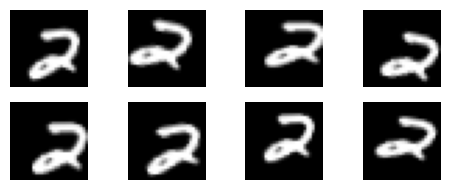

label id: 2 -> label name: 2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentacja - prezentacja działania (MNIST)
n = 515  # numer obrazka

mnist_datagen_aug = ImageDataGenerator(
    rescale=1.0/255.0,          # RAW 0..255 -> float 0..1
    rotation_range=15,          # MNIST: małe rotacje
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=[0.9, 1.1],
    shear_range=0.10,
    fill_mode="nearest"
)

# wybrany obrazek (28,28) -> (28,28,1) bo ImageDataGenerator lubi 4D: (N,H,W,C)
mnist_x0_raw = mnist_X_train_raw[n]                     # (28,28) uint8
mnist_x0_raw_4d = np.expand_dims(mnist_x0_raw, axis=(0, -1))  # (1,28,28,1)

mnist_it = mnist_datagen_aug.flow(
    mnist_x0_raw_4d,
    batch_size=1,
    shuffle=False,
    seed=123
)

# podgląd 8 augmentacji
plt.figure(figsize=(5, 2))
for i in range(8):
    x_aug = next(mnist_it)[0]                           # (28,28,1) float w [0..1]
    plt.subplot(2, 4, i + 1)
    plt.imshow(np.squeeze(np.clip(x_aug, 0.0, 1.0)), cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()


# etykieta (spójnie z projektem)
mnist_y0 = int(mnist_y_train[n])
print("label id:", mnist_y0, "->", "label name:", mnist_class_names[mnist_y0])



Augmentacja własciwa - przekształcone obrazki dodajemy tylko do train dodajemy do train

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# --- AUGMENTACJA -> DODANIE DO TRAIN (MNIST) ---
# augmentacja: losowy wybór + dokładanie do train, potem shuffle

mnist_aug_n_extra = 0  # ile dodatkowych próbek dorobić (0 => wyłączone)
mnist_aug_batch   = 256
mnist_aug_seed    = 123

mnist_datagen_aug = ImageDataGenerator(
    rescale=1.0/255.0,          # RAW 0..255 -> float 0..1
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=[0.9, 1.1],
    shear_range=0.10,
    fill_mode="nearest"
    # UWAGA: brak horizontal_flip i brightness_range dla MNIST
)

# X do generatora powinno być 4D: (N,H,W,C)
mnist_X_train_raw_4d = mnist_X_train_raw[..., np.newaxis]  # (N,28,28,1)

mnist_it_aug = mnist_datagen_aug.flow(
    mnist_X_train_raw_4d,   # RAW uint8 -> generator sam przeskaluje rescale
    mnist_y_train,          # (N,)
    batch_size=mnist_aug_batch,
    shuffle=True,
    seed=mnist_aug_seed
)

# bufory na augmenty (najpierw [0..1])
mnist_X_train_aug_scaled = np.empty((mnist_aug_n_extra, 28, 28), dtype=np.float32)  # trzymamy bez kanału
mnist_y_train_aug_extra  = np.empty((mnist_aug_n_extra,), dtype=np.int64)

mnist_filled = 0
while mnist_filled < mnist_aug_n_extra:
    x_batch_scaled_4d, y_batch = next(mnist_it_aug)  # x: (B,28,28,1)

    if y_batch.ndim > 1:
        y_batch = np.argmax(y_batch, axis=1)

    take = min(len(x_batch_scaled_4d), mnist_aug_n_extra - mnist_filled)

    # zrzucamy kanał: (B,28,28,1) -> (B,28,28)
    mnist_X_train_aug_scaled[mnist_filled:mnist_filled + take] = x_batch_scaled_4d[:take, ..., 0]
    mnist_y_train_aug_extra[mnist_filled:mnist_filled + take]  = y_batch[:take]

    mnist_filled += take

# standaryzacja augmentów tym samym mean/std co train (brak data leakage)
# mnist_mean, mnist_std mają shape (1,1,1) albo skalar – broadcast zadziała
mnist_X_train_aug_std = (mnist_X_train_aug_scaled - mnist_mean) / mnist_std

# DOŁĄCZENIE augmentów do TRAIN (nadpisujemy główne zmienne)
mnist_X_train_std = np.concatenate([mnist_X_train_std, mnist_X_train_aug_std], axis=0)
mnist_y_train     = np.concatenate([mnist_y_train,     mnist_y_train_aug_extra], axis=0)

# mieszanie train (żeby org/aug nie leżały blokami)
mnist_rng  = np.random.default_rng(mnist_aug_seed)
mnist_perm = mnist_rng.permutation(mnist_X_train_std.shape[0])
mnist_X_train_std = mnist_X_train_std[mnist_perm]
mnist_y_train     = mnist_y_train[mnist_perm]

print("mnist_X_train_std (po aug):", mnist_X_train_std.shape)  # (N+extra,28,28)
print("mnist_y_train     (po aug):", mnist_y_train.shape)      # (N+extra,)
print("mnist_X_test_std  (bez aug):", mnist_X_test_std.shape)  # (Ntest,28,28)

# --- REFRESH pipeline po augmentacji (żeby CNN/ML miały aktualne dane) ---
mnist_y_train_cls = mnist_y_train.astype(np.int64)

mnist_X_train_cnn  = mnist_X_train_std[..., np.newaxis]  # (N,28,28,1)
mnist_X_train_flat = mnist_X_train_std.reshape(mnist_X_train_std.shape[0], -1)  # (N,784)

print("mnist_X_train_cnn  (po aug):", mnist_X_train_cnn.shape)
print("mnist_X_train_flat (po aug):", mnist_X_train_flat.shape)
print("mnist_y_train_cls  (po aug):", mnist_y_train_cls.shape)



mnist_X_train_std (po aug): (60000, 28, 28)
mnist_y_train     (po aug): (60000,)
mnist_X_test_std  (bez aug): (10000, 28, 28)
mnist_X_train_cnn  (po aug): (60000, 28, 28, 1)
mnist_X_train_flat (po aug): (60000, 784)
mnist_y_train_cls  (po aug): (60000,)


### <a name='5'></a> 5. Spłaszczenie do modeli ML


In [ ]:
# Komórka — spłaszczenie obrazów MNIST pod modele ML (N, 28*28)
# Spłaszczenie dajemy do klasycznych modeli ML/PCA/LR/SVC itp.
# Do CNN NIE spłaszczamy (tam zostaje H, W, C).

mnist_X_train_flat = mnist_X_train_std.reshape(mnist_X_train_std.shape[0], -1)  # (N,784)
mnist_X_test_flat  = mnist_X_test_std.reshape(mnist_X_test_std.shape[0],  -1)  # (N,784)

print("mnist_X_train_flat:", mnist_X_train_flat.shape)
print("mnist_X_test_flat :", mnist_X_test_flat.shape)


mnist_X_train_flat: (60000, 784)
mnist_X_test_flat : (10000, 784)


### <a name='6'></a> 6. Wariancja skumulowana do PCA

In [ ]:
# PCA (MNIST): kilka wariantów n_components + zapis do słownika (pod porównania)
# Fit tylko na train, transform na test, zapis sumy wyjaśnionej wariancji (skumulowanej)

from sklearn.decomposition import PCA

mnist_pca_components_list = [32, 64, 128, 256]  # MNIST ma 784 cechy, więc te wartości są sensowne na start
mnist_pca_bundle = {}  # trzymamy: model PCA + transformacje + explained variance

for mnist_pca_n in mnist_pca_components_list:
    mnist_pca_model = PCA(n_components=mnist_pca_n, random_state=123)

    mnist_X_train_pca = mnist_pca_model.fit_transform(mnist_X_train_flat)  # fit tylko na train
    mnist_X_test_pca  = mnist_pca_model.transform(mnist_X_test_flat)       # transform test tym samym PCA

    mnist_pca_bundle[mnist_pca_n] = {
        "pca_model": mnist_pca_model,
        "X_train_pca": mnist_X_train_pca,
        "X_test_pca": mnist_X_test_pca,
        "explained_var_sum": float(mnist_pca_model.explained_variance_ratio_.sum()),
    }

    print(
        f"PCA={mnist_pca_n}: X_train_pca={mnist_X_train_pca.shape}, "
        f"explained_sum={mnist_pca_bundle[mnist_pca_n]['explained_var_sum']:.4f}"
    )


PCA=32: X_train_pca=(60000, 32), explained_sum=0.7436
PCA=64: X_train_pca=(60000, 64), explained_sum=0.8619
PCA=128: X_train_pca=(60000, 128), explained_sum=0.9364
PCA=256: X_train_pca=(60000, 256), explained_sum=0.9792


In [ ]:
# Wykres wariancji PCA (bar + cumulative line) dla wybranego n_components — MNIST

import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Wariant PCA (musi istnieć w mnist_pca_bundle)
mnist_pca_n_plot = 256  # dla jakiej ilości wymiarów PCA ma zostać stworzony wykres

mnist_pca_model_plot = mnist_pca_bundle[mnist_pca_n_plot]["pca_model"]
mnist_ev_ratio = mnist_pca_model_plot.explained_variance_ratio_
mnist_ev_cum = np.cumsum(mnist_ev_ratio)

mnist_pca_var_df = pd.DataFrame({
    "component": np.arange(1, len(mnist_ev_ratio) + 1),
    "explained_variance_ratio": mnist_ev_ratio,
    "cumulative": mnist_ev_cum
})

fig = go.Figure(data=[
    go.Bar(
        x=mnist_pca_var_df["component"],
        y=mnist_pca_var_df["explained_variance_ratio"],
        name="explained_variance_ratio"
    ),
    go.Scatter(
        x=mnist_pca_var_df["component"],
        y=mnist_pca_var_df["cumulative"],
        mode="lines+markers",
        name="cumulative",
        yaxis="y2"
    )
])

fig.update_layout(
    title=f"MNIST — PCA wariancja (n_components={mnist_pca_n_plot})",
    template="plotly_dark",
    width=950,
    height=550,
    xaxis=dict(title="component"),
    yaxis=dict(title="explained_variance_ratio"),
    yaxis2=dict(
        title="cumulative",
        overlaying="y",
        side="right",
        range=[0, 1.0]
    ),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.show()

assert mnist_pca_n_plot in mnist_pca_bundle, "Brak PCA o takiej liczbie komponentów — uruchom komórkę budującą mnist_pca_bundle."

# tabela (pierwsze 10 komponentów):
mnist_pca_var_df.head(10)


,component,explained_variance_ratio,cumulative
0,1,0.097038,0.097038
1,2,0.070950,0.167987
2,3,0.061684,0.229672
3,4,0.053900,0.283572
4,5,0.048709,0.332280
5,6,0.043117,0.375397
6,7,0.032723,0.408120
7,8,0.028835,0.436955
8,9,0.027618,0.464574
9,10,0.023567,0.488141


Struktura jak wygląda PCA dla 2 i 3 wymiarów danych wejściowych

In [ ]:
# PCA do wizualizacji (2D i 3D) + sampling — MNIST

import numpy as np
from sklearn.decomposition import PCA

# nazwy klas MNIST (0..9)
mnist_class_names = [str(i) for i in range(10)]

# spłaszcz pod PCA (zakładam, że masz mnist_X_train_std: (N,28,28))
mnist_X_train_flat = mnist_X_train_std.reshape(mnist_X_train_std.shape[0], -1)  # (N,784)

# sampling do plotów (żeby Plotly nie umarł)
mnist_viz_n = 5000
mnist_rng = np.random.default_rng(123)
mnist_viz_idx = mnist_rng.choice(mnist_X_train_flat.shape[0], size=mnist_viz_n, replace=False)

mnist_X_train_flat_viz = mnist_X_train_flat[mnist_viz_idx]
mnist_y_train_viz = mnist_y_train[mnist_viz_idx]

# PCA 2D i 3D (tylko pod wykresy)
mnist_pca_viz2_model = PCA(n_components=2, random_state=123)
mnist_X_train_pca2_viz = mnist_pca_viz2_model.fit_transform(mnist_X_train_flat_viz)

mnist_pca_viz3_model = PCA(n_components=3, random_state=123)
mnist_X_train_pca3_viz = mnist_pca_viz3_model.fit_transform(mnist_X_train_flat_viz)

print("PCA2 explained_sum:", float(mnist_pca_viz2_model.explained_variance_ratio_.sum()))
print("PCA3 explained_sum:", float(mnist_pca_viz3_model.explained_variance_ratio_.sum()))


PCA2 explained_sum: 0.16653764247894287
PCA3 explained_sum: 0.228838250041008


In [ ]:
# PCA 2D scatter (Plotly) — MNIST
# PCA dla PCA1/PCA2 - 2 wymiary

import pandas as pd
import plotly.express as px

mnist_pca2_df = pd.DataFrame({
    "pca_1": mnist_X_train_pca2_viz[:, 0],
    "pca_2": mnist_X_train_pca2_viz[:, 1],
    "class_id": mnist_y_train_viz
})
mnist_pca2_df["class_name"] = mnist_pca2_df["class_id"].map(lambda k: mnist_class_names[int(k)])

fig = px.scatter(
    mnist_pca2_df,
    x="pca_1", y="pca_2",
    color="class_name",
    opacity=0.55,
    template="plotly_dark",
    width=1000, height=600,
    title="MNIST — PCA 2D (2 wymiary PCA1/PCA2)"
)
fig.show()


In [ ]:
# PCA 3D scatter (Plotly) — MNIST
# PCA dla PCA1/PCA2/PCA3 - 3 wymiary

import pandas as pd
import plotly.express as px

mnist_pca3_df = pd.DataFrame({
    "pca_1": mnist_X_train_pca3_viz[:, 0],
    "pca_2": mnist_X_train_pca3_viz[:, 1],
    "pca_3": mnist_X_train_pca3_viz[:, 2],
    "class_id": mnist_y_train_viz
})
mnist_pca3_df["class_name"] = mnist_pca3_df["class_id"].map(lambda k: mnist_class_names[int(k)])

fig = px.scatter_3d(
    mnist_pca3_df,
    x="pca_1", y="pca_2", z="pca_3",
    color="class_name",
    opacity=0.60,
    template="plotly_dark",
    width=1000, height=700,
    title="MNIST — PCA 3D (sample)"
)
fig.show()


### <a name='7'></a> 7. Model PCA dla 256 wymiarów (~98% accuracy)


In [ ]:
# wybór wariantu PCA=256 + wygodne skróty do danych — MNIST
mnist_pca_n_final = 256

mnist_pca_final_model = mnist_pca_bundle[mnist_pca_n_final]["pca_model"]
mnist_X_train_pca_256 = mnist_pca_bundle[mnist_pca_n_final]["X_train_pca"]
mnist_X_test_pca_256  = mnist_pca_bundle[mnist_pca_n_final]["X_test_pca"]

mnist_pca_256_ev_sum = mnist_pca_bundle[mnist_pca_n_final]["explained_var_sum"]

print("mnist_X_train_pca_256:", mnist_X_train_pca_256.shape)
print("mnist_X_test_pca_256 :", mnist_X_test_pca_256.shape)
print("explained_var_sum:", mnist_pca_256_ev_sum)


mnist_X_train_pca_256: (60000, 256)
mnist_X_test_pca_256 : (10000, 256)
explained_var_sum: 0.9791867136955261


### <a name='8'></a> 8. Model Regresji Logistycznej - inicjalizacyjny - liniowy

In [ ]:
# INIT: magazyn predykcji do porównań (uruchomić raz, przed pierwszym modelem)
if "mnist_store_y_pred" not in globals():
    mnist_store_y_pred = {}


In [ ]:
# PCA=256 + Logistic Regression (MNIST) — wersja liniowa (OvR przez liblinear)
# "liniowy" tutaj = OvR (one-vs-rest) przez solver liblinear

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import plotly.express as px

# model (liblinear domyślnie robi OvR dla multi-class, więc nie ustawiamy multi_class -> brak warningów)
mnist_clf_pca_256_lr_lin = LogisticRegression(
    solver="liblinear",   # stabilny dla OvR
    max_iter=300,
    random_state=123
)

# trening
mnist_clf_pca_256_lr_lin.fit(mnist_X_train_pca_256, mnist_y_train)

# predykcja
mnist_y_pred_pca_256_lr_lin = mnist_clf_pca_256_lr_lin.predict(mnist_X_test_pca_256)

# metryki
mnist_acc_pca_256_lr_lin = accuracy_score(mnist_y_test, mnist_y_pred_pca_256_lr_lin)
mnist_f1m_pca_256_lr_lin = f1_score(mnist_y_test, mnist_y_pred_pca_256_lr_lin, average="macro")

print("LogReg (OvR) PCA=256 | accuracy:", mnist_acc_pca_256_lr_lin)
print("LogReg (OvR) PCA=256 | f1_macro:", mnist_f1m_pca_256_lr_lin)
print("\nclassification_report:\n",
      classification_report(mnist_y_test, mnist_y_pred_pca_256_lr_lin, target_names=mnist_class_names))

# confusion matrix
mnist_cm_pca_256_lr_lin = confusion_matrix(mnist_y_test, mnist_y_pred_pca_256_lr_lin)

mnist_cm_df_pca_256_lr_lin = pd.DataFrame(
    mnist_cm_pca_256_lr_lin,
    index=[f"true_{c}" for c in mnist_class_names],
    columns=[f"pred_{c}" for c in mnist_class_names]
)

fig = px.imshow(
    mnist_cm_df_pca_256_lr_lin,
    text_auto=True,
    aspect="auto",
    template="plotly_dark",
    title="MNIST | PCA=256 | Logistic Regression (OvR) | Confusion Matrix"
)
fig.show()

# pakiet wyników do porównań
mnist_results_pca_256_lr_lin = {
    "model_name": "LogisticRegression_OvR",
    "pca_n": 256,
    "explained_var_sum": mnist_pca_256_ev_sum,
    "accuracy": float(mnist_acc_pca_256_lr_lin),
    "f1_macro": float(mnist_f1m_pca_256_lr_lin),
    "confusion_matrix": mnist_cm_pca_256_lr_lin,
}

# predykcje do porównań init/best/per-klasa
mnist_store_y_pred["pca256_lr_lin"] = mnist_y_pred_pca_256_lr_lin

mnist_results_pca_256_lr_lin


LogReg (OvR) PCA=256 | accuracy: 0.9196
LogReg (OvR) PCA=256 | f1_macro: 0.9182199178867301

classification_report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.90      1010
           4       0.92      0.93      0.93       982
           5       0.89      0.85      0.87       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.92      1028
           8       0.88      0.87      0.87       974
           9       0.90      0.89      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



{'model_name': 'LogisticRegression_OvR',
 'pca_n': 256,
 'explained_var_sum': 0.9791867136955261,
 'accuracy': 0.9196,
 'f1_macro': 0.9182199178867301,
 'confusion_matrix': array([[ 961,    0,    1,    2,    0,    4,    5,    4,    1,    2],
        [   0, 1112,    3,    2,    0,    1,    4,    1,   12,    0],
        [  10,    7,  925,   20,    8,    2,   12,   10,   34,    4],
        [   4,    1,   21,  916,    2,   22,    3,   12,   20,    9],
        [   1,    1,    4,    3,  918,    0,    8,    2,    8,   37],
        [  11,    3,    2,   39,   11,  758,   19,    9,   32,    8],
        [   9,    3,    5,    2,    6,   16,  914,    0,    3,    0],
        [   3,   11,   23,    5,    6,    2,    1,  946,    3,   28],
        [  10,   10,    5,   20,   16,   32,   10,   12,  849,   10],
        [   8,    8,    2,   14,   33,   13,    0,   26,    8,  897]])}

### <a name='9'></a> 9. Model SVC - inicjalizacyjny

In [ ]:
# PCA=256 + Linear SVC (MNIST) — liniowy SVM (pełny run)

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import plotly.express as px

# model
mnist_clf_pca_256_svc_lin = LinearSVC(
    C=1.0,
    random_state=123
)

# trening
mnist_clf_pca_256_svc_lin.fit(mnist_X_train_pca_256, mnist_y_train)

# predykcja
mnist_y_pred_pca_256_svc_lin = mnist_clf_pca_256_svc_lin.predict(mnist_X_test_pca_256)

# metryki
mnist_acc_pca_256_svc_lin = accuracy_score(mnist_y_test, mnist_y_pred_pca_256_svc_lin)
mnist_f1m_pca_256_svc_lin = f1_score(mnist_y_test, mnist_y_pred_pca_256_svc_lin, average="macro")

print("LinearSVC PCA=256 | accuracy:", mnist_acc_pca_256_svc_lin)
print("LinearSVC PCA=256 | f1_macro:", mnist_f1m_pca_256_svc_lin)
print("\nclassification_report:\n",
      classification_report(mnist_y_test, mnist_y_pred_pca_256_svc_lin, target_names=mnist_class_names))

# confusion matrix
mnist_cm_pca_256_svc_lin = confusion_matrix(mnist_y_test, mnist_y_pred_pca_256_svc_lin)

mnist_cm_df_pca_256_svc_lin = pd.DataFrame(
    mnist_cm_pca_256_svc_lin,
    index=[f"true_{c}" for c in mnist_class_names],
    columns=[f"pred_{c}" for c in mnist_class_names]
)

fig = px.imshow(
    mnist_cm_df_pca_256_svc_lin,
    text_auto=True,
    aspect="auto",
    template="plotly_dark",
    title="MNIST | PCA=256 | LinearSVC | Confusion Matrix"
)
fig.show()

# pakiet wyników do porównań
mnist_results_pca_256_svc_lin = {
    "model_name": "LinearSVC_lin",
    "pca_n": 256,
    "explained_var_sum": mnist_pca_256_ev_sum,
    "accuracy": float(mnist_acc_pca_256_svc_lin),
    "f1_macro": float(mnist_f1m_pca_256_svc_lin),
    "confusion_matrix": mnist_cm_pca_256_svc_lin,
}

# predykcje do porównań init/best/per-klasa
mnist_store_y_pred["pca256_svc_lin"] = mnist_y_pred_pca_256_svc_lin

mnist_results_pca_256_svc_lin


LinearSVC PCA=256 | accuracy: 0.9187
LinearSVC PCA=256 | f1_macro: 0.9171676981248877

classification_report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.97      0.98      0.97      1135
           2       0.93      0.89      0.91      1032
           3       0.90      0.90      0.90      1010
           4       0.91      0.94      0.93       982
           5       0.89      0.85      0.87       892
           6       0.93      0.95      0.94       958
           7       0.93      0.92      0.93      1028
           8       0.88      0.86      0.87       974
           9       0.90      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



{'model_name': 'LinearSVC_lin',
 'pca_n': 256,
 'explained_var_sum': 0.9791867136955261,
 'accuracy': 0.9187,
 'f1_macro': 0.9171676981248877,
 'confusion_matrix': array([[ 961,    0,    1,    2,    0,    4,    5,    4,    1,    2],
        [   0, 1117,    2,    1,    0,    1,    4,    1,    9,    0],
        [  11,    7,  918,   19,   11,    2,   15,    9,   35,    5],
        [   5,    1,   23,  914,    2,   21,    3,   12,   20,    9],
        [   1,    1,    3,    3,  921,    0,    8,    2,    8,   35],
        [  11,    3,    3,   35,   12,  758,   18,   10,   33,    9],
        [   9,    3,    7,    2,    6,   16,  912,    0,    3,    0],
        [   2,    8,   22,    5,    6,    2,    2,  950,    2,   29],
        [  13,    9,    6,   22,   15,   35,   12,   13,  839,   10],
        [   8,    8,    2,   14,   35,   14,    0,   24,    7,  897]])}


### <a name='10'></a> 10. Przygotowanie wycinka danych do tuningu RL/SVC


In [ ]:
# Zbiór do tuningu (stratyfikowany podzbiór train) — MNIST
from sklearn.model_selection import train_test_split

mnist_tune_size = 30000  # można zmienić (maks 60000 w MNIST train)

mnist_X_train_pca_256_tune, _, mnist_y_train_tune, _ = train_test_split(
    mnist_X_train_pca_256,
    mnist_y_train,
    train_size=mnist_tune_size,
    random_state=123,
    stratify=mnist_y_train
)

uniq, cnt = np.unique(mnist_y_train_tune, return_counts=True)

print("tune class props:", (cnt/cnt.sum()).round(4))
print("tune X:", mnist_X_train_pca_256_tune.shape)
print("tune y:", mnist_y_train_tune.shape)


tune class props: [0.0987 0.1124 0.0993 0.1022 0.0974 0.0903 0.0986 0.1044 0.0975 0.0991]
tune X: (30000, 256)
tune y: (30000,)


### <a name='11'></a> 11. Tuner — Logistic Regression (PCA=256)

In [ ]:

# TUNER (FAST) — MNIST | PCA=256
# Cel: NIE mielić długo -> mały subset + mały grid
# Wyniki:
# - mnist_best_params_lr_pca256_fast, mnist_best_score_lr_pca256_fast
# - mnist_best_params_svc_rbf_approx_pca256_fast, mnist_best_score_svc_rbf_approx_pca256_fast

import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier

# -------------------------
# 0) FAST subset do tuningu
# -------------------------
mnist_tune_seed_fast = 123
mnist_tune_n_fast = 6000  # <-- klucz (6000–10000 zwykle OK)

mnist_rng_fast = np.random.default_rng(mnist_tune_seed_fast)
mnist_idx_fast = mnist_rng_fast.choice(
    mnist_X_train_pca_256.shape[0],
    size=mnist_tune_n_fast,
    replace=False
)

mnist_X_train_pca_256_tune_fast = mnist_X_train_pca_256[mnist_idx_fast]
mnist_y_train_tune_fast = mnist_y_train[mnist_idx_fast]

print("tune_fast X:", mnist_X_train_pca_256_tune_fast.shape)
print("tune_fast y:", mnist_y_train_tune_fast.shape)

# CV (3-fold) — minimalnie
mnist_cv_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

# -------------------------
# 1) Logistic Regression (liniowy) — FAST
# -------------------------
mnist_lr_fast = LogisticRegression(
    solver="liblinear",   # szybki dla OvR
    max_iter=300,
    random_state=123
)

mnist_param_grid_lr_fast = {"C": [0.3, 1.0, 3.0]}  # mały grid

mnist_grid_lr_pca256_fast = GridSearchCV(
    mnist_lr_fast,
    mnist_param_grid_lr_fast,
    scoring="f1_macro",
    cv=mnist_cv_fast,
    n_jobs=-1,
    verbose=2
)

mnist_grid_lr_pca256_fast.fit(mnist_X_train_pca_256_tune_fast, mnist_y_train_tune_fast)

mnist_best_params_lr_pca256_fast = mnist_grid_lr_pca256_fast.best_params_
mnist_best_score_lr_pca256_fast  = float(mnist_grid_lr_pca256_fast.best_score_)

print("\nBEST LR params (FAST):", mnist_best_params_lr_pca256_fast)
print("BEST LR cv f1_macro (FAST):", mnist_best_score_lr_pca256_fast)

# -------------------------
# 2) Nieliniowe (FAST) — RBF approx: RBFSampler + SGD hinge
#    (zamiennik SVC-RBF, ale 10x szybszy)
# -------------------------
mnist_svc_rbf_approx_fast = Pipeline([
    ("rbf", RBFSampler(random_state=123)),
    ("clf", SGDClassifier(loss="hinge", max_iter=2000, tol=1e-3, random_state=123))
])

mnist_param_grid_svc_rbf_approx_fast = {
    "rbf__gamma": [0.01, 0.03],
    "rbf__n_components": [300, 600],   # KLUCZ: mało komponentów = szybko
    "clf__alpha": [1e-4, 1e-3]
}

mnist_grid_svc_rbf_approx_pca256_fast = GridSearchCV(
    mnist_svc_rbf_approx_fast,
    mnist_param_grid_svc_rbf_approx_fast,
    scoring="f1_macro",
    cv=mnist_cv_fast,
    n_jobs=-1,
    verbose=2
)

mnist_grid_svc_rbf_approx_pca256_fast.fit(mnist_X_train_pca_256_tune_fast, mnist_y_train_tune_fast)

mnist_best_params_svc_rbf_approx_pca256_fast = mnist_grid_svc_rbf_approx_pca256_fast.best_params_
mnist_best_score_svc_rbf_approx_pca256_fast  = float(mnist_grid_svc_rbf_approx_pca256_fast.best_score_)

print("\nBEST SVC_RBF_APPROX params (FAST):", mnist_best_params_svc_rbf_approx_pca256_fast)
print("BEST SVC_RBF_APPROX cv f1_macro (FAST):", mnist_best_score_svc_rbf_approx_pca256_fast)


tune_fast X: (6000, 256)
tune_fast y: (6000,)
Fitting 3 folds for each of 3 candidates, totalling 9 fits

BEST LR params (FAST): {'C': 0.3}
BEST LR cv f1_macro (FAST): 0.8761545556358258
Fitting 3 folds for each of 8 candidates, totalling 24 fits

BEST SVC_RBF_APPROX params (FAST): {'clf__alpha': 0.0001, 'rbf__gamma': 0.01, 'rbf__n_components': 600}
BEST SVC_RBF_APPROX cv f1_macro (FAST): 0.3193745751630883


In [ ]:
"""

from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

mnist_cv_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

mnist_rbf_sgd_pipe = Pipeline([
    ("rbf", RBFSampler(random_state=123)),
    ("clf", SGDClassifier(loss="hinge", random_state=123))
])

mnist_param_grid_rbf_sgd = {
    "rbf__gamma": [0.01, 0.03],
    "rbf__n_components": [500, 1000],      # im więcej tym “bardziej RBF”
    "clf__alpha": [1e-4, 1e-3]             # regularyzacja
}

mnist_grid_rbf_sgd = GridSearchCV(
    mnist_rbf_sgd_pipe,
    mnist_param_grid_rbf_sgd,
    scoring="f1_macro",
    cv=mnist_cv_fast,
    n_jobs=-1,
    verbose=2
)

mnist_grid_rbf_sgd.fit(mnist_X_train_pca_256_tune, mnist_y_train_tune)

print("BEST RBF+SGD params:", mnist_grid_rbf_sgd.best_params_)
print("BEST RBF+SGD cv f1_macro:", float(mnist_grid_rbf_sgd.best_score_))


Fitting 3 folds for each of 8 candidates, totalling 24 fits
BEST RBF+SGD params: {'clf__alpha': 0.0001, 'rbf__gamma': 0.01, 'rbf__n_components': 1000}
BEST RBF+SGD cv f1_macro: 0.36192068905724


Sprawdzenie

In [ ]:
# CHECK: czy kluczowe wyniki tunera FAST istnieją
_need = [
    "mnist_best_params_lr_pca256_fast",
    "mnist_best_score_lr_pca256_fast",
    "mnist_best_params_svc_rbf_approx_pca256_fast",
    "mnist_best_score_svc_rbf_approx_pca256_fast",
]
_missing = [v for v in _need if v not in globals()]
print("MISSING:", _missing)
print("OK (found):", [v for v in _need if v in globals()])


MISSING: []
OK (found): ['mnist_best_params_lr_pca256_fast', 'mnist_best_score_lr_pca256_fast', 'mnist_best_params_svc_rbf_approx_pca256_fast', 'mnist_best_score_svc_rbf_approx_pca256_fast']


### <a name='12'></a> 12. Tuner — SVC

In [ ]:
"""
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

mnist_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

# =========================
# 1) Liniowy SVM (szybki): SGDClassifier(loss="hinge")
# =========================
mnist_svm_sgd = SGDClassifier(
    loss="hinge",        # liniowy SVM
    penalty="l2",
    max_iter=2000,
    tol=1e-3,
    random_state=123
)

mnist_param_grid_svm_sgd = {
    "alpha": [1e-4, 3e-4, 1e-3]   # regularyzacja (mniejsze alpha => słabsza regularyzacja)
}

mnist_grid_svm_sgd = GridSearchCV(
    estimator=mnist_svm_sgd,
    param_grid=mnist_param_grid_svm_sgd,
    scoring="f1_macro",
    cv=mnist_cv,
    n_jobs=-1,
    verbose=2
)

mnist_grid_svm_sgd.fit(mnist_X_train_pca_256_tune, mnist_y_train_tune)

mnist_best_params_svm_sgd_pca256 = mnist_grid_svm_sgd.best_params_
mnist_best_score_svm_sgd_pca256  = float(mnist_grid_svm_sgd.best_score_)

print("BEST SGD-hinge (linear SVM) params:", mnist_best_params_svm_sgd_pca256)
print("BEST SGD-hinge cv f1_macro:", mnist_best_score_svm_sgd_pca256)


# =========================
# 2) Nieliniowy: Nystroem(RBF) + LinearSVC
# =========================
mnist_nys_linearsvc = Pipeline([
    ("nys", Nystroem(kernel="rbf", random_state=123)),
    ("svc", LinearSVC())
])

mnist_param_grid_nys = {
    "nys__gamma": [0.01, 0.03],
    "nys__n_components": [300, 600],  # małe wartości = szybciej
    "svc__C": [0.3, 1.0, 3.0]
}

mnist_grid_nys = GridSearchCV(
    estimator=mnist_nys_linearsvc,
    param_grid=mnist_param_grid_nys,
    scoring="f1_macro",
    cv=mnist_cv,
    n_jobs=-1,
    verbose=2
)

mnist_grid_nys.fit(mnist_X_train_pca_256_tune, mnist_y_train_tune)

mnist_best_params_nys_pca256 = mnist_grid_nys.best_params_
mnist_best_score_nys_pca256  = float(mnist_grid_nys.best_score_)

print("BEST Nystroem+LinearSVC params:", mnist_best_params_nys_pca256)
print("BEST Nystroem+LinearSVC cv f1_macro:", mnist_best_score_nys_pca256)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
BEST SGD-hinge (linear SVM) params: {'alpha': 0.001}
BEST SGD-hinge cv f1_macro: 0.8193658028321368
Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST Nystroem+LinearSVC params: {'nys__gamma': 0.01, 'nys__n_components': 600, 'svc__C': 3.0}
BEST Nystroem+LinearSVC cv f1_macro: 0.7998222054270192


In [ ]:
# TUNER SVC (FAST) — MNIST | PCA=256
# 1) liniowy "SVM": SGDClassifier(loss="hinge")
# 2) nieliniowy: Nystroem(RBF) + LinearSVC
# Wymagane wejścia:
# - mnist_X_train_pca_256_tune_fast, mnist_y_train_tune_fast

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

mnist_cv_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

# ==========================================================
# 1) Liniowy "SVM": SGDClassifier(loss="hinge")  (FAST)
# ==========================================================
mnist_svc_lin_sgd_fast = SGDClassifier(
    loss="hinge",
    penalty="l2",
    max_iter=2000,
    tol=1e-3,
    random_state=123
)

mnist_param_grid_svc_lin_sgd_fast = {
    "alpha": [1e-4, 3e-4, 1e-3]
}

mnist_grid_svc_lin_sgd_pca256_fast = GridSearchCV(
    estimator=mnist_svc_lin_sgd_fast,
    param_grid=mnist_param_grid_svc_lin_sgd_fast,
    scoring="f1_macro",
    cv=mnist_cv_fast,
    n_jobs=-1,
    verbose=2
)

mnist_grid_svc_lin_sgd_pca256_fast.fit(mnist_X_train_pca_256_tune_fast, mnist_y_train_tune_fast)

mnist_best_params_svc_lin_sgd_pca256_fast = mnist_grid_svc_lin_sgd_pca256_fast.best_params_
mnist_best_score_svc_lin_sgd_pca256_fast  = float(mnist_grid_svc_lin_sgd_pca256_fast.best_score_)

print("BEST SVC_LIN_SGD params (FAST):", mnist_best_params_svc_lin_sgd_pca256_fast)
print("BEST SVC_LIN_SGD cv f1_macro (FAST):", mnist_best_score_svc_lin_sgd_pca256_fast)


# ==========================================================
# 2) Nieliniowy: Nystroem(RBF) + LinearSVC  (FAST)
# ==========================================================
mnist_svc_rbf_nystroem_fast = Pipeline([
    ("nys", Nystroem(kernel="rbf", random_state=123)),
    ("svc", LinearSVC(random_state=123))
])

mnist_param_grid_svc_rbf_nystroem_fast = {
    "nys__gamma": [0.01, 0.03],
    "nys__n_components": [200, 400],   # <-- FAST (300/600 bywa wolniejsze)
    "svc__C": [0.3, 1.0, 3.0]
}

mnist_grid_svc_rbf_nystroem_pca256_fast = GridSearchCV(
    estimator=mnist_svc_rbf_nystroem_fast,
    param_grid=mnist_param_grid_svc_rbf_nystroem_fast,
    scoring="f1_macro",
    cv=mnist_cv_fast,
    n_jobs=-1,
    verbose=2
)

mnist_grid_svc_rbf_nystroem_pca256_fast.fit(mnist_X_train_pca_256_tune_fast, mnist_y_train_tune_fast)

mnist_best_params_svc_rbf_nystroem_pca256_fast = mnist_grid_svc_rbf_nystroem_pca256_fast.best_params_
mnist_best_score_svc_rbf_nystroem_pca256_fast  = float(mnist_grid_svc_rbf_nystroem_pca256_fast.best_score_)

print("BEST SVC_RBF_NYSTROEM params (FAST):", mnist_best_params_svc_rbf_nystroem_pca256_fast)
print("BEST SVC_RBF_NYSTROEM cv f1_macro (FAST):", mnist_best_score_svc_rbf_nystroem_pca256_fast)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
BEST SVC_LIN_SGD params (FAST): {'alpha': 0.001}
BEST SVC_LIN_SGD cv f1_macro (FAST): 0.8850770926874069
Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST SVC_RBF_NYSTROEM params (FAST): {'nys__gamma': 0.01, 'nys__n_components': 400, 'svc__C': 3.0}
BEST SVC_RBF_NYSTROEM cv f1_macro (FAST): 0.7901120490700121


### <a name='13'></a> 13. Regresja Logistyczna - na najlepszych parametrach

In [ ]:
# PCA=256 + Logistic Regression (BEST z tunera, pełny run) — MNIST (liniowy OvR)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import plotly.express as px

# --- BEST param z tunera (fallback jeśli nie istnieje) ---
if "mnist_best_params_lr_pca256_fast" in globals() and "C" in mnist_best_params_lr_pca256_fast:
    mnist_lr_best_C = float(mnist_best_params_lr_pca256_fast["C"])
elif "mnist_best_params_lr_pca256" in globals() and "C" in mnist_best_params_lr_pca256:
    mnist_lr_best_C = float(mnist_best_params_lr_pca256["C"])
else:
    mnist_lr_best_C = 3.0  # fallback

# model (liniowy: OvR)
mnist_clf_pca_256_lr_best = LogisticRegression(
    C=mnist_lr_best_C,
    multi_class="ovr",
    solver="liblinear",
    max_iter=500,
    random_state=123
)

# trening
mnist_clf_pca_256_lr_best.fit(mnist_X_train_pca_256, mnist_y_train)

# predykcja
mnist_y_pred_pca_256_lr_best = mnist_clf_pca_256_lr_best.predict(mnist_X_test_pca_256)

# --- STORE predykcji (klucz spójny) ---
if "mnist_store_y_pred" not in globals():
    mnist_store_y_pred = {}
mnist_store_y_pred["pca256_lr_best"] = mnist_y_pred_pca_256_lr_best

# metryki
mnist_acc_pca_256_lr_best = accuracy_score(mnist_y_test, mnist_y_pred_pca_256_lr_best)
mnist_f1m_pca_256_lr_best = f1_score(mnist_y_test, mnist_y_pred_pca_256_lr_best, average="macro")

print("LogReg PCA=256 | BEST C:", mnist_lr_best_C)
print("LogReg PCA=256 | accuracy:", mnist_acc_pca_256_lr_best)
print("LogReg PCA=256 | f1_macro:", mnist_f1m_pca_256_lr_best)
print("\nclassification_report:\n",
      classification_report(mnist_y_test, mnist_y_pred_pca_256_lr_best, target_names=mnist_class_names))

# confusion matrix
mnist_cm_pca_256_lr_best = confusion_matrix(mnist_y_test, mnist_y_pred_pca_256_lr_best)

mnist_cm_df_pca_256_lr_best = pd.DataFrame(
    mnist_cm_pca_256_lr_best,
    index=[f"true_{c}" for c in mnist_class_names],
    columns=[f"pred_{c}" for c in mnist_class_names]
)

fig = px.imshow(
    mnist_cm_df_pca_256_lr_best,
    text_auto=True,
    aspect="auto",
    template="plotly_dark",
    title=f"MNIST | PCA=256 | Logistic Regression (BEST C={mnist_lr_best_C}) | Confusion Matrix"
)
fig.show()

# pakiet wyników do porównań (BEST)
mnist_results_pca_256_lr_best = {
    "model_name": "LogisticRegression_OvR",
    "pca_n": 256,
    "best_params": {"C": mnist_lr_best_C},
    "explained_var_sum": mnist_pca_256_ev_sum,
    "accuracy": float(mnist_acc_pca_256_lr_best),
    "f1_macro": float(mnist_f1m_pca_256_lr_best),
    "confusion_matrix": mnist_cm_pca_256_lr_best,
}

# alias (żeby nie było NameError w Twoim store)
mnist_results_pca256_lr_best = mnist_results_pca_256_lr_best

mnist_results_pca_256_lr_best


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.



LogReg PCA=256 | BEST C: 0.3
LogReg PCA=256 | accuracy: 0.9184
LogReg PCA=256 | f1_macro: 0.9169622734489866

classification_report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.90      1010
           4       0.91      0.93      0.92       982
           5       0.89      0.85      0.87       892
           6       0.93      0.95      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.87      0.87      0.87       974
           9       0.90      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



{'model_name': 'LogisticRegression_OvR',
 'pca_n': 256,
 'best_params': {'C': 0.3},
 'explained_var_sum': 0.9791867136955261,
 'accuracy': 0.9184,
 'f1_macro': 0.9169622734489866,
 'confusion_matrix': array([[ 961,    0,    1,    2,    0,    4,    5,    4,    1,    2],
        [   0, 1111,    3,    2,    0,    1,    4,    1,   13,    0],
        [  11,    7,  924,   19,    9,    2,   11,   11,   34,    4],
        [   5,    1,   21,  915,    2,   22,    3,   12,   20,    9],
        [   1,    3,    4,    3,  917,    0,    9,    1,    8,   36],
        [  11,    3,    2,   39,   12,  756,   21,    8,   31,    9],
        [   9,    3,    5,    2,    6,   16,  914,    0,    3,    0],
        [   3,    9,   23,    5,    7,    2,    1,  946,    3,   29],
        [  11,   10,    6,   19,   17,   32,   12,   14,  843,   10],
        [   8,    8,    2,   14,   33,   13,    0,   26,    8,  897]])}

### <a name='14'></a> 14. SVC - Na najlepszych parametrach

In [ ]:
# PCA=256 + LinearSVC (BEST z tunera, pełny run) — MNIST

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import plotly.express as px

# BEST param z tunera (podstaw z: mnist_best_params_linearsvc_pca256["C"])
mnist_svc_best_C = 0.3

# model
mnist_clf_pca_256_svc_best = LinearSVC(
    C=mnist_svc_best_C,
    random_state=123
)

# trening
mnist_clf_pca_256_svc_best.fit(mnist_X_train_pca_256, mnist_y_train)

# predykcja
mnist_y_pred_pca_256_svc_best = mnist_clf_pca_256_svc_best.predict(mnist_X_test_pca_256)

# metryki
mnist_acc_pca_256_svc_best = accuracy_score(mnist_y_test, mnist_y_pred_pca_256_svc_best)
mnist_f1m_pca_256_svc_best = f1_score(mnist_y_test, mnist_y_pred_pca_256_svc_best, average="macro")

print("LinearSVC PCA=256 | BEST C:", mnist_svc_best_C)
print("LinearSVC PCA=256 | accuracy:", mnist_acc_pca_256_svc_best)
print("LinearSVC PCA=256 | f1_macro:", mnist_f1m_pca_256_svc_best)
print("\nclassification_report:\n",
      classification_report(mnist_y_test, mnist_y_pred_pca_256_svc_best, target_names=mnist_class_names))

# confusion matrix
mnist_cm_pca_256_svc_best = confusion_matrix(mnist_y_test, mnist_y_pred_pca_256_svc_best)

mnist_cm_df_pca_256_svc_best = pd.DataFrame(
    mnist_cm_pca_256_svc_best,
    index=[f"true_{c}" for c in mnist_class_names],
    columns=[f"pred_{c}" for c in mnist_class_names]
)

fig = px.imshow(
    mnist_cm_df_pca_256_svc_best,
    text_auto=True,
    aspect="auto",
    template="plotly_dark",
    title=f"MNIST | PCA=256 | LinearSVC (BEST C={mnist_svc_best_C}) | Confusion Matrix"
)
fig.show()

# pakiet wyników do porównań (BEST)
mnist_results_pca_256_svc_best = {
    "model_name": "LinearSVC",
    "pca_n": 256,
    "best_params": {"C": mnist_svc_best_C},
    "explained_var_sum": mnist_pca_256_ev_sum,
    "accuracy": float(mnist_acc_pca_256_svc_best),
    "f1_macro": float(mnist_f1m_pca_256_svc_best),
    "confusion_matrix": mnist_cm_pca_256_svc_best,
}

# --- store predykcji do porównań ---
mnist_store_y_pred["pca256_svc_best"] = mnist_y_pred_pca_256_svc_best

# alias (żeby nie było NameError w Twoim store)
mnist_results_pca256_svc_best = mnist_results_pca_256_svc_best

print("store keys:", sorted(mnist_store_y_pred.keys()))

mnist_results_pca_256_svc_best


LinearSVC PCA=256 | BEST C: 0.3
LinearSVC PCA=256 | accuracy: 0.9186
LinearSVC PCA=256 | f1_macro: 0.9170621665155062

classification_report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.97      0.98      0.98      1135
           2       0.93      0.89      0.91      1032
           3       0.90      0.90      0.90      1010
           4       0.91      0.94      0.93       982
           5       0.89      0.85      0.87       892
           6       0.93      0.95      0.94       958
           7       0.93      0.92      0.92      1028
           8       0.88      0.86      0.87       974
           9       0.90      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



store keys: ['pca256_lr_best', 'pca256_lr_lin', 'pca256_svc_best', 'pca256_svc_lin']


{'model_name': 'LinearSVC',
 'pca_n': 256,
 'best_params': {'C': 0.3},
 'explained_var_sum': 0.9791867136955261,
 'accuracy': 0.9186,
 'f1_macro': 0.9170621665155062,
 'confusion_matrix': array([[ 961,    0,    1,    2,    0,    4,    5,    4,    1,    2],
        [   0, 1117,    2,    1,    0,    1,    4,    1,    9,    0],
        [  11,    6,  918,   19,   11,    2,   15,    9,   36,    5],
        [   5,    1,   23,  914,    2,   21,    3,   12,   20,    9],
        [   1,    1,    3,    3,  921,    0,    8,    2,    8,   35],
        [  11,    3,    3,   35,   12,  758,   18,   10,   33,    9],
        [   9,    3,    7,    2,    6,   16,  913,    0,    2,    0],
        [   2,    8,   22,    5,    6,    2,    2,  949,    2,   30],
        [  13,    9,    6,   21,   15,   35,   13,   13,  839,   10],
        [   8,    8,    2,   14,   36,   14,    0,   24,    7,  896]])}

### <a name='15'></a> 15. Podsumowanie Regresji Logistycznej (Init / best param) + SVC (Initial/ best param)

In [ ]:
import numpy as np
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import classification_report, confusion_matrix

# --- sanity-check: czy predykcje istnieją i mają dobry kształt ---
required_preds = [
    "mnist_y_pred_pca_256_lr_lin",
    "mnist_y_pred_pca_256_lr_best",
    "mnist_y_pred_pca_256_svc_lin",
    "mnist_y_pred_pca_256_svc_best",
]
for v in required_preds:
    if v not in globals():
        raise NameError(f"Brakuje zmiennej: {v}. Uruchom komórkę modelu, która ją tworzy.")

# spójność długości predykcji z y_test
n_test = len(mnist_y_test)
for v in required_preds:
    if len(globals()[v]) != n_test:
        raise ValueError(f"{v} ma długość {len(globals()[v])}, a mnist_y_test ma {n_test} — coś jest nie tak z danymi/testem.")


# =========================
# INPUTY (MNIST) — muszą istnieć
# =========================
# mnist_y_test
# mnist_class_names
# mnist_y_pred_pca_256_lr_lin
# mnist_y_pred_pca_256_lr_best
# mnist_y_pred_pca_256_svc_lin
# mnist_y_pred_pca_256_svc_best


def _build_per_class_tables(y_true, y_pred_init, y_pred_best, class_names):
    # --- F1 per klasa ---
    rep_init = classification_report(
        y_true, y_pred_init, target_names=class_names,
        output_dict=True, zero_division=0
    )
    rep_best = classification_report(
        y_true, y_pred_best, target_names=class_names,
        output_dict=True, zero_division=0
    )

    df_f1 = pd.DataFrame({
        "class": class_names,
        "support": [rep_init[c]["support"] for c in class_names],
        "f1_init": [rep_init[c]["f1-score"] for c in class_names],
        "f1_best": [rep_best[c]["f1-score"] for c in class_names],
    })
    df_f1["f1_delta"] = df_f1["f1_best"] - df_f1["f1_init"]

    # --- poprawne trafienia per klasa (z przekątnej CM) ---
    labels = np.arange(len(class_names))
    cm_init = confusion_matrix(y_true, y_pred_init, labels=labels)
    cm_best = confusion_matrix(y_true, y_pred_best, labels=labels)

    init_correct = np.diag(cm_init).astype(int)
    best_correct = np.diag(cm_best).astype(int)
    delta_correct = (best_correct - init_correct).astype(int)

    df_hits = pd.DataFrame({
        "class": class_names,
        "support": df_f1["support"].values,
        "correct_init": init_correct,
        "correct_best": best_correct,
        "delta_correct": delta_correct,
        # % względem poprawnych init (uwaga: jak init=0, to % jest bez sensu -> NaN)
        "delta_correct_pct_vs_init_correct": np.where(
            init_correct > 0, 100.0 * delta_correct / init_correct, np.nan
        ),
        # % względem liczności klasy (zawsze ma sens)
        "delta_correct_pct_vs_support": np.where(
            df_f1["support"].values > 0, 100.0 * delta_correct / df_f1["support"].values, np.nan
        )
    })

    # --- podsumowanie globalne ---
    total_init_correct = int(init_correct.sum())
    total_best_correct = int(best_correct.sum())
    total_delta = total_best_correct - total_init_correct

    df_total = pd.DataFrame([{
        "total_correct_init": total_init_correct,
        "total_correct_best": total_best_correct,
        "total_delta_correct": total_delta,
        "total_delta_correct_pct_vs_init_correct": (100.0 * total_delta / total_init_correct) if total_init_correct > 0 else np.nan,
        "total_delta_correct_pct_vs_support": (100.0 * total_delta / len(y_true)) if len(y_true) > 0 else np.nan,
    }])

    return df_f1, df_hits, df_total


# =========================
# 1) LR: init vs best
# =========================
df_lr_f1, df_lr_hits, df_lr_total = _build_per_class_tables(
    mnist_y_test,
    mnist_y_pred_pca_256_lr_lin,     # init
    mnist_y_pred_pca_256_lr_best,    # best
    mnist_class_names
)

# =========================
# 2) SVC: init vs best
# =========================
df_svc_f1, df_svc_hits, df_svc_total = _build_per_class_tables(
    mnist_y_test,
    mnist_y_pred_pca_256_svc_lin,    # init
    mnist_y_pred_pca_256_svc_best,   # best
    mnist_class_names
)

# =========================
# WYKRES: 2 bargrafy OBOK SIEBIE (bez sumowania)
# =========================
classes = mnist_class_names

lr_init = df_lr_f1.set_index("class").loc[classes, "f1_init"].values
lr_best = df_lr_f1.set_index("class").loc[classes, "f1_best"].values

svc_init = df_svc_f1.set_index("class").loc[classes, "f1_init"].values
svc_best = df_svc_f1.set_index("class").loc[classes, "f1_best"].values

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=[
        "LogisticRegression | F1 per klasa (init vs best)",
        "LinearSVC | F1 per klasa (init vs best)"
    ]
)

fig.add_trace(go.Bar(x=classes, y=lr_init, name="LR init"), row=1, col=1)
fig.add_trace(go.Bar(x=classes, y=lr_best, name="LR best"), row=1, col=1)

fig.add_trace(go.Bar(x=classes, y=svc_init, name="SVC init"), row=1, col=2)
fig.add_trace(go.Bar(x=classes, y=svc_best, name="SVC best"), row=1, col=2)

fig.update_layout(
    barmode="group",
    title="MNIST | PCA=256 | Porównanie F1 per klasa: init vs best",
    legend_title="Wariant"
)

# MNIST ma zwykle wysokie F1, więc sensowny zakres Y (żeby widać było różnice)
fig.update_yaxes(range=[0.80, 1.00], row=1, col=1)
fig.update_yaxes(range=[0.80, 1.00], row=1, col=2)

fig.update_xaxes(tickangle=45)
fig.show()

# =========================
# TABELE: poprawa o ile elementów i % (per klasa + globalnie)
# =========================
print("\n=== LogisticRegression: F1 per klasa (init/best/delta) ===")
display(df_lr_f1.sort_values("f1_delta", ascending=False))

print("\n=== LogisticRegression: poprawne trafienia per klasa (init/best/delta + %) ===")
display(df_lr_hits.sort_values("delta_correct", ascending=False))

print("\n=== LogisticRegression: podsumowanie globalne poprawnych trafień ===")
display(df_lr_total)

print("\n=== LinearSVC: F1 per klasa (init/best/delta) ===")
display(df_svc_f1.sort_values("f1_delta", ascending=False))

print("\n=== LinearSVC: poprawne trafienia per klasa (init/best/delta + %) ===")
display(df_svc_hits.sort_values("delta_correct", ascending=False))

print("\n=== LinearSVC: podsumowanie globalne poprawnych trafień ===")
display(df_svc_total)



=== LogisticRegression: F1 per klasa (init/best/delta) ===


,class,support,f1_init,f1_best,f1_delta
3,3,1010.0,0.901131,0.901478,0.000346
9,9,1009.0,0.895210,0.894763,-0.000446
1,1,1135.0,0.970755,0.970306,-0.000449
7,7,1028.0,0.922927,0.922477,-0.000450
2,2,1032.0,0.914483,0.913495,-0.000989
5,5,892.0,0.870264,0.868966,-0.001299
0,0,980.0,0.962444,0.961000,-0.001444
6,6,958.0,0.945191,0.943240,-0.001951
4,4,982.0,0.926337,0.923929,-0.002408
8,8,974.0,0.873457,0.869969,-0.003488



=== LogisticRegression: poprawne trafienia per klasa (init/best/delta + %) ===


,class,support,correct_init,correct_best,delta_correct,delta_correct_pct_vs_init_correct,delta_correct_pct_vs_support
0,0,980.0,961,961,0,0.000000,0.000000
7,7,1028.0,946,946,0,0.000000,0.000000
6,6,958.0,914,914,0,0.000000,0.000000
9,9,1009.0,897,897,0,0.000000,0.000000
1,1,1135.0,1112,1111,-1,-0.089928,-0.088106
2,2,1032.0,925,924,-1,-0.108108,-0.096899
3,3,1010.0,916,915,-1,-0.109170,-0.099010
4,4,982.0,918,917,-1,-0.108932,-0.101833
5,5,892.0,758,756,-2,-0.263852,-0.224215
8,8,974.0,849,843,-6,-0.706714,-0.616016



=== LogisticRegression: podsumowanie globalne poprawnych trafień ===


,total_correct_init,total_correct_best,total_delta_correct,total_delta_correct_pct_vs_init_correct,total_delta_correct_pct_vs_support
0,9196,9184,-12,-0.130492,-0.12



=== LinearSVC: F1 per klasa (init/best/delta) ===


,class,support,f1_init,f1_best,f1_delta
3,3,1010.0,0.901825,0.902270,0.000445
1,1,1135.0,0.974695,0.975120,0.000425
6,6,958.0,0.941662,0.941723,0.000060
0,0,980.0,0.960520,0.960520,0.000000
5,5,892.0,0.868768,0.868768,0.000000
2,2,1032.0,0.909361,0.909361,0.000000
8,8,974.0,0.868980,0.868980,0.000000
4,4,982.0,0.925628,0.925163,-0.000465
7,7,1028.0,0.925475,0.924951,-0.000524
9,9,1009.0,0.894763,0.893766,-0.000998



=== LinearSVC: poprawne trafienia per klasa (init/best/delta + %) ===


,class,support,correct_init,correct_best,delta_correct,delta_correct_pct_vs_init_correct,delta_correct_pct_vs_support
6,6,958.0,912,913,1,0.109649,0.104384
0,0,980.0,961,961,0,0.000000,0.000000
1,1,1135.0,1117,1117,0,0.000000,0.000000
2,2,1032.0,918,918,0,0.000000,0.000000
4,4,982.0,921,921,0,0.000000,0.000000
3,3,1010.0,914,914,0,0.000000,0.000000
5,5,892.0,758,758,0,0.000000,0.000000
8,8,974.0,839,839,0,0.000000,0.000000
7,7,1028.0,950,949,-1,-0.105263,-0.097276
9,9,1009.0,897,896,-1,-0.111483,-0.099108



=== LinearSVC: podsumowanie globalne poprawnych trafień ===


,total_correct_init,total_correct_best,total_delta_correct,total_delta_correct_pct_vs_init_correct,total_delta_correct_pct_vs_support
0,9187,9186,-1,-0.010885,-0.01


### <a name='16'></a> 16. Siec neuronowa CNN initial guess

In [ ]:
# LIGHT CNN (MNIST) + regularizacja + dropout (mniej warstw, szybciej)

import numpy as np
import tensorflow as tf
from tensorflow import keras as krs
from tensorflow.keras import layers as L

mnist_num_classes = 10
mnist_input_shape = (28, 28, 1)

# --- WAŻNE: odśwież wejście CNN (zwłaszcza jeśli była augmentacja i nadpisanie mnist_X_train_std) ---
mnist_X_train_cnn = mnist_X_train_std[..., np.newaxis]
mnist_X_test_cnn  = mnist_X_test_std[..., np.newaxis]
print("mnist_X_train_cnn:", mnist_X_train_cnn.shape, "| mnist_X_test_cnn:", mnist_X_test_cnn.shape)

# etykiety jako 1D int (pod sparse_categorical_crossentropy)
mnist_y_train_cls = mnist_y_train.reshape(-1).astype(np.int64)
mnist_y_test_cls  = mnist_y_test.reshape(-1).astype(np.int64)

def build_mnist_cnn_light(
    input_shape=mnist_input_shape,
    num_classes=mnist_num_classes,
    base_filters=32,
    l2_reg=1e-4,
    dropout_conv=0.10,
    dropout_head=0.30,
    activation="relu"
):
    reg = krs.regularizers.l2(l2_reg)

    inputs = krs.Input(shape=input_shape, name="mnist_input")
    x = inputs

    # --- Block 1 (28x28 -> 14x14) ---
    x = L.Conv2D(base_filters, 3, padding="same", kernel_regularizer=reg, use_bias=False, name="mnist_lconv1")(x)
    x = L.BatchNormalization(name="mnist_lbn1")(x)
    x = L.Activation(activation, name="mnist_lact1")(x)

    x = L.MaxPool2D(pool_size=2, name="mnist_lpool1")(x)
    x = L.Dropout(dropout_conv, name="mnist_ldrop1")(x)

    # --- Block 2 (14x14 -> 7x7) ---
    x = L.Conv2D(base_filters * 2, 3, padding="same", kernel_regularizer=reg, use_bias=False, name="mnist_lconv2")(x)
    x = L.BatchNormalization(name="mnist_lbn2")(x)
    x = L.Activation(activation, name="mnist_lact2")(x)

    x = L.MaxPool2D(pool_size=2, name="mnist_lpool2")(x)
    x = L.Dropout(dropout_conv, name="mnist_ldrop2")(x)

    # --- Head ---
    x = L.GlobalAveragePooling2D(name="mnist_lgap")(x)
    x = L.Dropout(dropout_head, name="mnist_ldrop_head")(x)

    x = L.Dense(128, kernel_regularizer=reg, use_bias=False, name="mnist_ldense1")(x)
    x = L.BatchNormalization(name="mnist_lbn_dense1")(x)
    x = L.Activation(activation, name="mnist_lact_dense1")(x)
    x = L.Dropout(dropout_head, name="mnist_ldrop_dense1")(x)

    outputs = L.Dense(num_classes, activation="softmax", name="mnist_out")(x)

    model = krs.Model(inputs, outputs, name="mnist_cnn_light")
    return model

# instancja + compile
mnist_model_cnn_light = build_mnist_cnn_light()

mnist_model_cnn_light.compile(
    optimizer=krs.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

mnist_model_cnn_light.summary()


mnist_X_train_cnn: (60000, 28, 28, 1) | mnist_X_test_cnn: (10000, 28, 28, 1)


Model: "mnist_cnn_light"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mnist_input (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_lconv1 (Conv2D)           │ (None, 28, 28, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_lbn1 (BatchNormalization) │ (None, 28, 28, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_lact1 (Activation)        │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_lpool1 (MaxPooling2D)     │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_ldrop1 (Dropout)          │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_lconv2 (Conv2D)           │ (None, 14, 14, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_lbn2 (BatchNormalization) │ (None, 14, 14, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_lact2 (Activation)        │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_lpool2 (MaxPooling2D)     │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_ldrop2 (Dropout)          │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_lgap                      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_ldrop_head (Dropout)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_ldense1 (Dense)           │ (None, 128)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_lbn_dense1                │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_lact_dense1 (Activation)  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_ldrop_dense1 (Dropout)    │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_out (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,098 (113.66 KB)

 Trainable params: 28,650 (111.91 KB)

 Non-trainable params: 448 (1.75 KB)

### <a name='17'></a> 17. Trening sieci na danych wejściowych bez spłaszczania

In [ ]:
import numpy as np

# 1) twarda kontrola spójności
print("X_std:", mnist_X_train_std.shape, " y:", mnist_y_train.shape)
assert mnist_X_train_std.shape[0] == mnist_y_train.shape[0], "NIEZGODNE: X_train_std vs y_train"

print("X_test_std:", mnist_X_test_std.shape, " y_test:", mnist_y_test.shape)
assert mnist_X_test_std.shape[0] == mnist_y_test.shape[0], "NIEZGODNE: X_test_std vs y_test"

# 1b) kontrola kształtu obrazów (żeby nie trenować przypadkiem na spłaszczonych)
assert mnist_X_train_std.ndim == 3 and mnist_X_train_std.shape[1:] == (28, 28), "X_train_std ma zły kształt (oczekuję N,28,28)"
assert mnist_X_test_std.ndim == 3 and mnist_X_test_std.shape[1:] == (28, 28), "X_test_std ma zły kształt (oczekuję N,28,28)"

# 2) dopiero teraz twórz wejście do CNN i etykiety
mnist_X_train_cnn = mnist_X_train_std[..., np.newaxis].astype(np.float32)
mnist_X_test_cnn  = mnist_X_test_std[..., np.newaxis].astype(np.float32)

mnist_y_train_cls = np.asarray(mnist_y_train).reshape(-1).astype(np.int64)
mnist_y_test_cls  = np.asarray(mnist_y_test).reshape(-1).astype(np.int64)

print("FINAL X_train_cnn:", mnist_X_train_cnn.shape, " FINAL y_train_cls:", mnist_y_train_cls.shape)
print("FINAL X_test_cnn :", mnist_X_test_cnn.shape,  " FINAL y_test_cls :", mnist_y_test_cls.shape)


X_std: (60000, 28, 28)  y: (60000,)
X_test_std: (10000, 28, 28)  y_test: (10000,)
FINAL X_train_cnn: (60000, 28, 28, 1)  FINAL y_train_cls: (60000,)
FINAL X_test_cnn : (10000, 28, 28, 1)  FINAL y_test_cls : (10000,)


mnist_X_train_cnn: (60000, 28, 28, 1) float32
mnist_y_train_cls: (60000,) int64


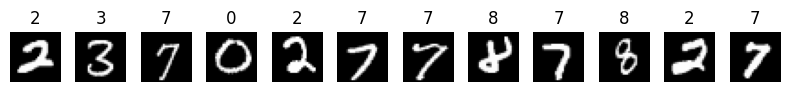

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

print("mnist_X_train_cnn:", mnist_X_train_cnn.shape, mnist_X_train_cnn.dtype)
print("mnist_y_train_cls:", mnist_y_train_cls.shape, mnist_y_train_cls.dtype)

idx = np.random.default_rng(123).choice(mnist_y_train_cls.shape[0], size=12, replace=False)

plt.figure(figsize=(8, 2))
for i, k in enumerate(idx):
    plt.subplot(1, 12, i + 1)
    plt.imshow(mnist_X_train_cnn[k, ..., 0], cmap="gray")
    plt.title(int(mnist_y_train_cls[k]))
    plt.axis("off")
plt.tight_layout()
plt.show()


Trening

In [ ]:
# reset modelu (NOWA instancja)
mnist_model_cnn_light = build_mnist_cnn_light()

mnist_model_cnn_light.compile(
    optimizer=krs.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

mnist_callbacks_light = [
    krs.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
    krs.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5)
]

print("mnist_X_train_cnn:", mnist_X_train_cnn.shape, mnist_X_train_cnn.dtype)
print("mnist_y_train_cls:", mnist_y_train_cls.shape, mnist_y_train_cls.dtype)
print("mnist_X_test_cnn :", mnist_X_test_cnn.shape, mnist_X_test_cnn.dtype)
print("mnist_y_test_cls :", mnist_y_test_cls.shape, mnist_y_test_cls.dtype)


mnist_hist_cnn_light = mnist_model_cnn_light.fit(
    mnist_X_train_cnn, mnist_y_train_cls,
    validation_split=0.1,
    epochs=20,
    batch_size=128,
    callbacks=mnist_callbacks_light,
    verbose=1
)

mnist_eval_cnn_light = mnist_model_cnn_light.evaluate(mnist_X_test_cnn, mnist_y_test_cls, verbose=0)
print("mnist_eval_cnn_light (loss, acc):", mnist_eval_cnn_light)

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import pandas as pd
import plotly.express as px

# predykcje na teście
mnist_y_pred_cnn_light_proba = mnist_model_cnn_light.predict(mnist_X_test_cnn, verbose=0)
mnist_y_pred_cnn_light = np.argmax(mnist_y_pred_cnn_light_proba, axis=1)

# metryki
mnist_acc_cnn_light = accuracy_score(mnist_y_test_cls, mnist_y_pred_cnn_light)
mnist_f1m_cnn_light = f1_score(mnist_y_test_cls, mnist_y_pred_cnn_light, average="macro")

print("MNIST | CNN_LIGHT | accuracy:", mnist_acc_cnn_light)
print("MNIST | CNN_LIGHT | f1_macro:", mnist_f1m_cnn_light)
print("\nclassification_report:\n",
      classification_report(mnist_y_test_cls, mnist_y_pred_cnn_light, target_names=mnist_class_names))

# confusion matrix
mnist_cm_cnn_light = confusion_matrix(mnist_y_test_cls, mnist_y_pred_cnn_light)

mnist_cm_df_cnn_light = pd.DataFrame(
    mnist_cm_cnn_light,
    index=[f"true_{c}" for c in mnist_class_names],
    columns=[f"pred_{c}" for c in mnist_class_names]
)

fig = px.imshow(
    mnist_cm_df_cnn_light,
    text_auto=True,
    aspect="auto",
    template="plotly_dark",
    title="MNIST | CNN_LIGHT | Confusion Matrix"
)
fig.show()

# paczka wyników do porównań
mnist_results_cnn_light = {
    "model_name": "CNN_LIGHT",
    "pca_n": None,
    "best_params": None,
    "explained_var_sum": None,
    "accuracy": float(mnist_acc_cnn_light),
    "f1_macro": float(mnist_f1m_cnn_light),
    "confusion_matrix": mnist_cm_cnn_light,
}

# store predykcji (dla późniejszych porównań)
mnist_store_y_pred["cnn_light"] = mnist_y_pred_cnn_light



mnist_X_train_cnn: (60000, 28, 28, 1) float32
mnist_y_train_cls: (60000,) int64
mnist_X_test_cnn : (10000, 28, 28, 1) float32
mnist_y_test_cls : (10000,) int64
Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 95s 215ms/step - accuracy: 0.3228 - loss: 1.9032 - val_accuracy: 0.1858 - val_loss: 3.1293 - learning_rate: 0.0010
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 138s 206ms/step - accuracy: 0.6509 - loss: 0.9933 - val_accuracy: 0.4300 - val_loss: 1.6287 - learning_rate: 0.0010
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 87s 205ms/step - accuracy: 0.8479 - loss: 0.4926 - val_accuracy: 0.9010 - val_loss: 0.3246 - learning_rate: 0.0010
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 85s 202ms/step - accuracy: 0.8984 - loss: 0.3383 - val_accuracy: 0.9632 - val_loss: 0.1515 - learning_rate: 0.0010
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 143s 205ms/step - accuracy: 0.9159 - loss: 0.2898 - val_accuracy: 0.9638 - val_loss: 0.1437 - learning_rate: 0.0010
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 85s 202ms/step - accura

### <a name='18'></a> 18. Podsumowanie sieci - inicjal parameters

In [ ]:
#powyżej już zrobiłem podsumowanie
"""
# SUMMARY / TESTY dla LIGHT CNN — MNIST (metryki + confusion matrix jak dla LR/SVC)

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import plotly.express as px
import numpy as np

# 1) podgląd architektury
mnist_model_cnn_light.summary()

# 2) predykcje na teście
mnist_y_pred_cnn_light_proba = mnist_model_cnn_light.predict(mnist_X_test_cnn, verbose=0)
mnist_y_pred_cnn_light = np.argmax(mnist_y_pred_cnn_light_proba, axis=1)

# 3) metryki
mnist_acc_cnn_light = accuracy_score(mnist_y_test_cls, mnist_y_pred_cnn_light)
mnist_f1m_cnn_light = f1_score(mnist_y_test_cls, mnist_y_pred_cnn_light, average="macro")

print("CNN LIGHT | accuracy:", mnist_acc_cnn_light)
print("CNN LIGHT | f1_macro:", mnist_f1m_cnn_light)
print("\nclassification_report:\n",
      classification_report(mnist_y_test_cls, mnist_y_pred_cnn_light, target_names=mnist_class_names))

# 4) confusion matrix
mnist_cm_cnn_light = confusion_matrix(mnist_y_test_cls, mnist_y_pred_cnn_light)

mnist_cm_df_cnn_light = pd.DataFrame(
    mnist_cm_cnn_light,
    index=[f"true_{c}" for c in mnist_class_names],
    columns=[f"pred_{c}" for c in mnist_class_names]
)

fig = px.imshow(
    mnist_cm_df_cnn_light,
    text_auto=True,
    aspect="auto",
    template="plotly_dark",
    title="MNIST | CNN LIGHT | Confusion Matrix"
)
fig.show()

# 5) paczka wyników do porównań
mnist_results_cnn_light = {
    "model_name": "CNN_LIGHT",
    "pca_n": None,
    "best_params": None,
    "explained_var_sum": None,
    "accuracy": float(mnist_acc_cnn_light),
    "f1_macro": float(mnist_f1m_cnn_light),
    "confusion_matrix": mnist_cm_cnn_light,
}
mnist_results_cnn_light


Model: "mnist_cnn_light"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mnist_input (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_lconv1 (Conv2D)           │ (None, 28, 28, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_lbn1 (BatchNormalization) │ (None, 28, 28, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_lact1 (Activation)        │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_lpool1 (MaxPooling2D)     │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_ldrop1 (Dropout)          │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_lconv2 (Conv2D)           │ (None, 14, 14, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_lbn2 (BatchNormalization) │ (None, 14, 14, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_lact2 (Activation)        │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_lpool2 (MaxPooling2D)     │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_ldrop2 (Dropout)          │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_lgap                      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_ldrop_head (Dropout)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_ldense1 (Dense)           │ (None, 128)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_lbn_dense1                │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_lact_dense1 (Activation)  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_ldrop_dense1 (Dropout)    │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_out (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,400 (337.50 KB)

 Trainable params: 28,650 (111.91 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 57,302 (223.84 KB)

CNN LIGHT | accuracy: 0.9846
CNN LIGHT | f1_macro: 0.9845824918502505

classification_report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.99      0.98       892
           6       0.98      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



{'model_name': 'CNN_LIGHT',
 'pca_n': None,
 'best_params': None,
 'explained_var_sum': None,
 'accuracy': 0.9846,
 'f1_macro': 0.9845824918502505,
 'confusion_matrix': array([[ 969,    1,    3,    0,    0,    0,    6,    1,    0,    0],
        [   0, 1132,    2,    1,    0,    0,    0,    0,    0,    0],
        [   5,    1, 1014,    4,    0,    4,    0,    1,    2,    1],
        [   0,    0,    0, 1002,    0,    4,    0,    3,    0,    1],
        [   0,    2,    1,    0,  965,    0,    3,    2,    0,    9],
        [   1,    1,    2,    5,    1,  879,    2,    1,    0,    0],
        [   1,    6,    0,    0,    1,    3,  946,    0,    1,    0],
        [   0,   10,    5,    0,    0,    0,    0, 1013,    0,    0],
        [   5,    0,    5,    2,    2,    3,    4,    0,  952,    1],
        [   7,    7,    5,    1,    5,    1,    1,    5,    3,  974]])}

### <a name='19'></a> 19. Tuner 1 (liczba bloków konwolucji i funkcja aktywacji)

In [ ]:
# TUNER #1 (minimalny): liczba bloków conv + aktywacja — MNIST (mało prób, mało epok, subset danych)

%pip -q install -U keras-tuner

import keras_tuner as kt
from tensorflow import keras as krs
from tensorflow.keras import layers as L
import numpy as np

# szybki subset żeby tuner nie mielił pół dnia
mnist_tuner1_seed = 123
mnist_tuner1_n = min(20000, mnist_X_train_cnn.shape[0])

mnist_rng = np.random.default_rng(mnist_tuner1_seed)
mnist_idx = mnist_rng.choice(mnist_X_train_cnn.shape[0], size=mnist_tuner1_n, replace=False)

mnist_X_train_cnn_tuner1 = mnist_X_train_cnn[mnist_idx]
mnist_y_train_cls_tuner1 = mnist_y_train_cls[mnist_idx]

# rejestry wyników (żeby podsumowanie było zawsze możliwe)
mnist_results_registry = {}   # tu wrzucamy paczki mnist_results_*
# mnist_store_y_pred


def build_mnist_cnn_tuner1(hp: kt.HyperParameters):
    activation   = hp.Choice("activation", ["relu", "elu", "gelu"])
    n_blocks     = hp.Int("n_blocks", min_value=1, max_value=3, step=1)
    base_filters = hp.Choice("base_filters", [16, 32, 48])
    dropout_conv = hp.Float("dropout_conv", 0.00, 0.25, step=0.05)
    dropout_head = hp.Float("dropout_head", 0.10, 0.50, step=0.10)
    l2_reg       = hp.Choice("l2_reg", [1e-5, 1e-4, 1e-3])

    reg = krs.regularizers.l2(l2_reg)

    inputs = krs.Input(shape=(28, 28, 1), name="mnist_input")
    x = inputs

    filters = base_filters
    for b in range(n_blocks):
        x = L.Conv2D(filters, 3, padding="same", kernel_regularizer=reg, use_bias=False, name=f"mnist_t1_conv{b+1}")(x)
        x = L.BatchNormalization(name=f"mnist_t1_bn{b+1}")(x)
        x = L.Activation(activation, name=f"mnist_t1_act{b+1}")(x)
        x = L.MaxPool2D(pool_size=2, name=f"mnist_t1_pool{b+1}")(x)
        x = L.Dropout(dropout_conv, name=f"mnist_t1_drop{b+1}")(x)
        filters = min(filters * 2, 128)

    x = L.GlobalAveragePooling2D(name="mnist_t1_gap")(x)
    x = L.Dropout(dropout_head, name="mnist_t1_drop_head")(x)

    dense_units = hp.Choice("dense_units", [64, 128, 256])
    x = L.Dense(dense_units, kernel_regularizer=reg, use_bias=False, name="mnist_t1_dense")(x)
    x = L.BatchNormalization(name="mnist_t1_bn_dense")(x)
    x = L.Activation(activation, name="mnist_t1_act_dense")(x)
    x = L.Dropout(dropout_head, name="mnist_t1_drop_dense")(x)

    outputs = L.Dense(10, activation="softmax", name="mnist_out")(x)

    model = krs.Model(inputs, outputs, name="mnist_cnn_tuner1")

    lr = hp.Choice("lr", [1e-3, 5e-4, 2e-4])
    model.compile(
        optimizer=krs.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


mnist_tuner1 = kt.RandomSearch(
    hypermodel=build_mnist_cnn_tuner1,
    objective="val_accuracy",
    max_trials=6,                 # MINIMALNIE
    executions_per_trial=1,
    overwrite=True,
    directory="kt_mnist",
    project_name="tuner1_blocks_activation"
)

mnist_callbacks_tuner1 = [
    krs.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)
]

mnist_tuner1.search(
    mnist_X_train_cnn_tuner1, mnist_y_train_cls_tuner1,
    validation_split=0.15,
    epochs=6,                   # MINIMALNIE
    batch_size=128,
    callbacks=mnist_callbacks_tuner1,
    verbose=1
)

mnist_best_hp_tuner1 = mnist_tuner1.get_best_hyperparameters(1)[0]
print("BEST HP TUNER1:", mnist_best_hp_tuner1.values)

# zapis best HP (żeby później nie zgubić)
mnist_best_hp_tuner1_dict = dict(mnist_best_hp_tuner1.values)
mnist_results_registry["cnn_tuned1_hp"] = mnist_best_hp_tuner1_dict



Trial 6 Complete [00h 07m 48s]
val_accuracy: 0.749666690826416

Best val_accuracy So Far: 0.9366666674613953
Total elapsed time: 00h 28m 52s
BEST HP TUNER1: {'activation': 'gelu', 'n_blocks': 3, 'base_filters': 48, 'dropout_conv': 0.0, 'dropout_head': 0.1, 'l2_reg': 0.001, 'dense_units': 128, 'lr': 0.001}


### <a name='20'></a> 20. Tuner 1 trening na best parameters

In [ ]:
# Podsumowanie + pełny trening BEST modelu z tunera #1 (MNIST, cały train) + testy + CM
# (spójne X/y: mnist_X_train_cnn / mnist_y_train_cls)

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import plotly.express as px
from tensorflow import keras as krs

# 0) rejestry (jeśli jeszcze nie istnieją)
if "mnist_store_y_pred" not in globals():
    mnist_store_y_pred = {}
if "mnist_results_registry" not in globals():
    mnist_results_registry = {}

# 1) bezpieczeństwo: spójność długości
assert mnist_X_train_cnn.shape[0] == mnist_y_train_cls.shape[0]
assert mnist_X_test_cnn.shape[0]  == mnist_y_test_cls.shape[0]

# 2) porządek w grafie TF (ważne przy wielu modelach)
krs.backend.clear_session()

# 3) budujemy BEST model z tunera #1
mnist_model_cnn_tuned1 = build_mnist_cnn_tuner1(mnist_best_hp_tuner1)
mnist_model_cnn_tuned1.summary()

# 4) trening (ES + ReduceLR jak w LIGHT)
mnist_callbacks_tuned1 = [
    krs.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
    krs.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5)
]

mnist_hist_cnn_tuned1 = mnist_model_cnn_tuned1.fit(
    mnist_X_train_cnn, mnist_y_train_cls,
    validation_split=0.1,
    epochs=20,
    batch_size=128,
    callbacks=mnist_callbacks_tuned1,
    verbose=1
)

# 5) test
mnist_y_pred_cnn_tuned1_proba = mnist_model_cnn_tuned1.predict(mnist_X_test_cnn, verbose=0)
mnist_y_pred_cnn_tuned1 = np.argmax(mnist_y_pred_cnn_tuned1_proba, axis=1)

mnist_acc_cnn_tuned1 = accuracy_score(mnist_y_test_cls, mnist_y_pred_cnn_tuned1)
mnist_f1m_cnn_tuned1 = f1_score(mnist_y_test_cls, mnist_y_pred_cnn_tuned1, average="macro")

print("CNN TUNED #1 | accuracy:", mnist_acc_cnn_tuned1)
print("CNN TUNED #1 | f1_macro:", mnist_f1m_cnn_tuned1)
print("\nclassification_report:\n",
      classification_report(mnist_y_test_cls, mnist_y_pred_cnn_tuned1, target_names=mnist_class_names))

# 6) confusion matrix
mnist_cm_cnn_tuned1 = confusion_matrix(mnist_y_test_cls, mnist_y_pred_cnn_tuned1)

mnist_cm_df_cnn_tuned1 = pd.DataFrame(
    mnist_cm_cnn_tuned1,
    index=[f"true_{c}" for c in mnist_class_names],
    columns=[f"pred_{c}" for c in mnist_class_names]
)

fig = px.imshow(
    mnist_cm_df_cnn_tuned1,
    text_auto=True,
    aspect="auto",
    template="plotly_dark",
    title="MNIST | CNN TUNED #1 | Confusion Matrix"
)
fig.show()

# 7) paczka wyników do porównań + rejestracja
mnist_results_cnn_tuned1 = {
    "model_name": "CNN_TUNED_1",
    "pca_n": None,
    "best_params": dict(mnist_best_hp_tuner1.values),
    "explained_var_sum": None,
    "accuracy": float(mnist_acc_cnn_tuned1),
    "f1_macro": float(mnist_f1m_cnn_tuned1),
    "confusion_matrix": mnist_cm_cnn_tuned1,
}

mnist_store_y_pred["cnn_tuned1"] = mnist_y_pred_cnn_tuned1
mnist_results_registry["cnn_tuned1"] = mnist_results_cnn_tuned1

mnist_results_cnn_tuned1


Model: "mnist_cnn_tuner1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mnist_input (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t1_conv1 (Conv2D)         │ (None, 28, 28, 48)     │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t1_bn1                    │ (None, 28, 28, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t1_act1 (Activation)      │ (None, 28, 28, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t1_pool1 (MaxPooling2D)   │ (None, 14, 14, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t1_drop1 (Dropout)        │ (None, 14, 14, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t1_conv2 (Conv2D)         │ (None, 14, 14, 96)     │        41,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t1_bn2                    │ (None, 14, 14, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t1_act2 (Activation)      │ (None, 14, 14, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t1_pool2 (MaxPooling2D)   │ (None, 7, 7, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t1_drop2 (Dropout)        │ (None, 7, 7, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t1_conv3 (Conv2D)         │ (None, 7, 7, 128)      │       110,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t1_bn3                    │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t1_act3 (Activation)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t1_pool3 (MaxPooling2D)   │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t1_drop3 (Dropout)        │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t1_gap                    │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t1_drop_head (Dropout)    │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t1_dense (Dense)          │ (None, 128)            │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t1_bn_dense               │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t1_act_dense (Activation) │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t1_drop_dense (Dropout)   │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 171,770 (670.98 KB)

 Trainable params: 170,970 (667.85 KB)

 Non-trainable params: 800 (3.12 KB)

Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 271s 635ms/step - accuracy: 0.8667 - loss: 0.7301 - val_accuracy: 0.7597 - val_loss: 0.8165 - learning_rate: 0.0010
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 257s 610ms/step - accuracy: 0.9814 - loss: 0.2172 - val_accuracy: 0.9685 - val_loss: 0.1985 - learning_rate: 0.0010
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 257s 610ms/step - accuracy: 0.9867 - loss: 0.1410 - val_accuracy: 0.9540 - val_loss: 0.2235 - learning_rate: 0.0010
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 263s 613ms/step - accuracy: 0.9861 - loss: 0.1177 - val_accuracy: 0.9708 - val_loss: 0.1574 - learning_rate: 0.0010
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 261s 612ms/step - accuracy: 0.9877 - loss: 0.1046 - val_accuracy: 0.9722 - val_loss: 0.1466 - learning_rate: 0.0010
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 258s 612ms/step - accuracy: 0.9889 - loss: 0.0963 - val_accuracy: 0.9623 - val_loss: 0.1750 - learning_rate: 0.0010
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 256s 606ms/step - accura

{'model_name': 'CNN_TUNED_1',
 'pca_n': None,
 'best_params': {'activation': 'gelu',
  'n_blocks': 3,
  'base_filters': 48,
  'dropout_conv': 0.0,
  'dropout_head': 0.1,
  'l2_reg': 0.001,
  'dense_units': 128,
  'lr': 0.001},
 'explained_var_sum': None,
 'accuracy': 0.9883,
 'f1_macro': 0.9882649944490343,
 'confusion_matrix': array([[ 978,    0,    0,    0,    0,    0,    1,    1,    0,    0],
        [   0, 1131,    0,    3,    0,    0,    0,    1,    0,    0],
        [   1,    1, 1007,    9,    0,    3,    0,    8,    2,    1],
        [   0,    0,    0, 1009,    0,    1,    0,    0,    0,    0],
        [   0,    4,    0,    0,  956,    0,    1,    0,    1,   20],
        [   0,    0,    0,    6,    0,  885,    1,    0,    0,    0],
        [   4,    6,    0,    0,    1,    7,  940,    0,    0,    0],
        [   0,    7,    1,    2,    0,    2,    0, 1014,    2,    0],
        [   1,    0,    0,    2,    1,    2,    0,    0,  968,    0],
        [   0,    0,    0,    0,    0,   

### <a name='21'></a> 21. Tuner 2 - zmienia funkcje aktywacji / szer filtru / dropout / L2 reg, ilość neuronow i regularyzacje

In [ ]:
# TUNER #2 Hyperband — MNIST
# Hyperband = "successive halving" — dużo konfiguracji krótko, najlepsze dostają więcej epok

import keras_tuner as kt
from tensorflow import keras as krs
from tensorflow.keras import layers as L

def build_mnist_cnn_tuner2(hp: kt.HyperParameters):
    activation   = hp.Choice("activation", ["relu", "elu", "gelu"])
    base_filters = hp.Choice("base_filters", [16, 32, 64])
    dropout_conv = hp.Float("dropout_conv", 0.00, 0.25, step=0.05)
    dropout_head = hp.Float("dropout_head", 0.10, 0.50, step=0.10)
    l2_reg       = hp.Choice("l2_reg", [1e-5, 1e-4, 1e-3])

    reg = krs.regularizers.l2(l2_reg)

    inputs = krs.Input(shape=(28, 28, 1), name="mnist_input")
    x = inputs

    # 2 bloki (light), tuner kręci szerokością + regularyzacją
    x = L.Conv2D(base_filters, 3, padding="same", kernel_regularizer=reg, use_bias=False, name="mnist_t2_conv1")(x)
    x = L.BatchNormalization(name="mnist_t2_bn1")(x)
    x = L.Activation(activation, name="mnist_t2_act1")(x)
    x = L.MaxPool2D(2, name="mnist_t2_pool1")(x)
    x = L.Dropout(dropout_conv, name="mnist_t2_drop1")(x)

    x = L.Conv2D(base_filters * 2, 3, padding="same", kernel_regularizer=reg, use_bias=False, name="mnist_t2_conv2")(x)
    x = L.BatchNormalization(name="mnist_t2_bn2")(x)
    x = L.Activation(activation, name="mnist_t2_act2")(x)
    x = L.MaxPool2D(2, name="mnist_t2_pool2")(x)
    x = L.Dropout(dropout_conv, name="mnist_t2_drop2")(x)

    x = L.GlobalAveragePooling2D(name="mnist_t2_gap")(x)
    x = L.Dropout(dropout_head, name="mnist_t2_drop_head")(x)

    dense_units = hp.Choice("dense_units", [64, 128, 256])
    x = L.Dense(dense_units, kernel_regularizer=reg, use_bias=False, name="mnist_t2_dense")(x)
    x = L.BatchNormalization(name="mnist_t2_bn_dense")(x)
    x = L.Activation(activation, name="mnist_t2_act_dense")(x)
    x = L.Dropout(dropout_head, name="mnist_t2_drop_dense")(x)

    outputs = L.Dense(10, activation="softmax", name="mnist_out")(x)

    model = krs.Model(inputs, outputs, name="mnist_cnn_tuner2")

    lr = hp.Choice("lr", [1e-3, 5e-4, 2e-4, 1e-4])
    model.compile(
        optimizer=krs.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


mnist_tuner2 = kt.Hyperband(
    hypermodel=build_mnist_cnn_tuner2,
    objective="val_accuracy",
    max_epochs=10,              # mało
    factor=3,
    hyperband_iterations=1,     # mało
    overwrite=True,
    directory="kt_mnist",
    project_name="tuner2_hyperband"
)

mnist_callbacks_tuner2 = [
    krs.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)
]

# znów subset (żeby było szybko) — używamy tego samego co tuner1:
mnist_tuner2.search(
    mnist_X_train_cnn_tuner1, mnist_y_train_cls_tuner1,
    validation_split=0.15,
    epochs=10,
    batch_size=128,
    callbacks=mnist_callbacks_tuner2,
    verbose=1
)

mnist_best_hp_tuner2 = mnist_tuner2.get_best_hyperparameters(1)[0]
print("BEST HP TUNER2:", mnist_best_hp_tuner2.values)

# --- rejestr (żeby potem nie szukać gdzie jest best_hp) ---
if "mnist_results_registry" not in globals():
    mnist_results_registry = {}

mnist_results_registry["cnn_tuned2_best_hp"] = {
    "model_name": "CNN_TUNED_2_BEST_HP",
    "best_params": dict(mnist_best_hp_tuner2.values),
    "note": "Best hyperparameters from tuner2 (Hyperband) on subset"
}



Trial 30 Complete [00h 04m 34s]
val_accuracy: 0.7696666717529297

Best val_accuracy So Far: 0.9636666774749756
Total elapsed time: 01h 22m 14s
BEST HP TUNER2: {'activation': 'relu', 'base_filters': 32, 'dropout_conv': 0.0, 'dropout_head': 0.1, 'l2_reg': 0.0001, 'dense_units': 64, 'lr': 0.001, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


### <a name='22'></a> 22. Tuner 2 trening na best parameters

In [ ]:
# Podsumowanie + pełny trening BEST modelu z tunera #2 — MNIST + testy + CM
# (trzymamy poprawiony pipeline: mnist_X_train_cnn / mnist_y_train_cls)

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import plotly.express as px

# 0) bezpieczeństwo: spójność długości
assert mnist_X_train_cnn.shape[0] == mnist_y_train_cls.shape[0]
assert mnist_X_test_cnn.shape[0]  == mnist_y_test_cls.shape[0]

# 0b) rejestry (żeby podsumowania zawsze działały)
if "mnist_store_y_pred" not in globals():
    mnist_store_y_pred = {}

if "mnist_results_registry" not in globals():
    mnist_results_registry = {}

# 1) BEST model z tunera #2
krs.backend.clear_session()  # porządek w TF (szczególnie po tunerach)
mnist_model_cnn_tuned2 = build_mnist_cnn_tuner2(mnist_best_hp_tuner2)
mnist_model_cnn_tuned2.summary()

# 2) trening (jak po korektach: ES + ReduceLR)
mnist_callbacks_tuned2 = [
    krs.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
    krs.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5)
]

mnist_hist_cnn_tuned2 = mnist_model_cnn_tuned2.fit(
    mnist_X_train_cnn, mnist_y_train_cls,
    validation_split=0.1,
    epochs=20,
    batch_size=128,
    callbacks=mnist_callbacks_tuned2,
    verbose=1
)

# 3) test
mnist_y_pred_cnn_tuned2_proba = mnist_model_cnn_tuned2.predict(mnist_X_test_cnn, verbose=0)
mnist_y_pred_cnn_tuned2 = np.argmax(mnist_y_pred_cnn_tuned2_proba, axis=1)

mnist_acc_cnn_tuned2 = accuracy_score(mnist_y_test_cls, mnist_y_pred_cnn_tuned2)
mnist_f1m_cnn_tuned2 = f1_score(mnist_y_test_cls, mnist_y_pred_cnn_tuned2, average="macro")

print("CNN TUNED #2 | accuracy:", mnist_acc_cnn_tuned2)
print("CNN TUNED #2 | f1_macro:", mnist_f1m_cnn_tuned2)
print("\nclassification_report:\n",
      classification_report(mnist_y_test_cls, mnist_y_pred_cnn_tuned2, target_names=mnist_class_names))

mnist_cm_cnn_tuned2 = confusion_matrix(mnist_y_test_cls, mnist_y_pred_cnn_tuned2)

mnist_cm_df_cnn_tuned2 = pd.DataFrame(
    mnist_cm_cnn_tuned2,
    index=[f"true_{c}" for c in mnist_class_names],
    columns=[f"pred_{c}" for c in mnist_class_names]
)

fig = px.imshow(
    mnist_cm_df_cnn_tuned2,
    text_auto=True,
    aspect="auto",
    template="plotly_dark",
    title="MNIST | CNN TUNED #2 | Confusion Matrix"
)
fig.show()

# 4) paczka wyników do porównań
mnist_results_cnn_tuned2 = {
    "model_name": "CNN_TUNED_2",
    "pca_n": None,
    "best_params": dict(mnist_best_hp_tuner2.values),
    "explained_var_sum": None,
    "accuracy": float(mnist_acc_cnn_tuned2),
    "f1_macro": float(mnist_f1m_cnn_tuned2),
    "confusion_matrix": mnist_cm_cnn_tuned2,
}

# 5) store predykcji (dla porównań / testów statystycznych / “init vs best” itp.)
mnist_store_y_pred["cnn_tuned2"] = mnist_y_pred_cnn_tuned2

# 6) rejestr wyników (żeby podsumowanie nigdy nie zginęło)
mnist_results_registry["cnn_tuned2"] = mnist_results_cnn_tuned2

mnist_results_cnn_tuned2


Model: "mnist_cnn_tuner2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mnist_input (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t2_conv1 (Conv2D)         │ (None, 28, 28, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t2_bn1                    │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t2_act1 (Activation)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t2_pool1 (MaxPooling2D)   │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t2_drop1 (Dropout)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t2_conv2 (Conv2D)         │ (None, 14, 14, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t2_bn2                    │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t2_act2 (Activation)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t2_pool2 (MaxPooling2D)   │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t2_drop2 (Dropout)        │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t2_gap                    │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t2_drop_head (Dropout)    │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t2_dense (Dense)          │ (None, 64)             │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t2_bn_dense               │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t2_act_dense (Activation) │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_t2_drop_dense (Dropout)   │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_out (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,106 (94.16 KB)

 Trainable params: 23,786 (92.91 KB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 82s 189ms/step - accuracy: 0.4937 - loss: 1.4843 - val_accuracy: 0.3535 - val_loss: 1.8683 - learning_rate: 0.0010
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 82s 189ms/step - accuracy: 0.8786 - loss: 0.3995 - val_accuracy: 0.8415 - val_loss: 0.4695 - learning_rate: 0.0010
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 79s 186ms/step - accuracy: 0.9412 - loss: 0.2096 - val_accuracy: 0.9582 - val_loss: 0.1651 - learning_rate: 0.0010
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 83s 189ms/step - accuracy: 0.9571 - loss: 0.1590 - val_accuracy: 0.9652 - val_loss: 0.1278 - learning_rate: 0.0010
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 79s 187ms/step - accuracy: 0.9616 - loss: 0.1385 - val_accuracy: 0.9790 - val_loss: 0.0868 - learning_rate: 0.0010
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 79s 187ms/step - accuracy: 0.9694 - loss: 0.1166 - val_accuracy: 0.9798 - val_loss: 0.0849 - learning_rate: 0.0010
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 79s 188ms/step - accuracy: 0.9

{'model_name': 'CNN_TUNED_2',
 'pca_n': None,
 'best_params': {'activation': 'relu',
  'base_filters': 32,
  'dropout_conv': 0.0,
  'dropout_head': 0.1,
  'l2_reg': 0.0001,
  'dense_units': 64,
  'lr': 0.001,
  'tuner/epochs': 10,
  'tuner/initial_epoch': 0,
  'tuner/bracket': 0,
  'tuner/round': 0},
 'explained_var_sum': None,
 'accuracy': 0.9879,
 'f1_macro': 0.9878296274543267,
 'confusion_matrix': array([[ 966,    1,    3,    0,    1,    1,    6,    1,    1,    0],
        [   0, 1131,    2,    0,    1,    0,    1,    0,    0,    0],
        [   2,    1, 1020,    0,    0,    4,    0,    2,    3,    0],
        [   0,    0,    0, 1006,    0,    2,    0,    1,    0,    1],
        [   0,    0,    0,    0,  970,    0,    0,    3,    2,    7],
        [   0,    0,    1,    6,    0,  882,    1,    1,    1,    0],
        [   2,    5,    0,    0,    0,    2,  945,    0,    4,    0],
        [   0,    5,    5,    0,    2,    0,    0, 1015,    0,    1],
        [   1,    1,    2,    2,    

Podsumowanie bez modelu z walidacją krzyżową

In [ ]:
# PODSUMOWANIE WSZYSTKICH MODELI — MNIST (accuracy + f1_macro) [bez CV na razie]
# Cel: brak NameError, stabilne nazwy, działa nawet jak nie wszystkie modele są w pamięci.

import pandas as pd
import plotly.express as px

# -----------------------------------------
# 1) Lista kandydatów (NIE wywala NameError)
# -----------------------------------------
mnist_results_candidates = [
    ("pca256_lr_lin",   "LR init (OvR) | PCA256",  "mnist_results_pca_256_lr_lin"),
    ("pca256_lr_best",  "LR best (OvR) | PCA256",  "mnist_results_pca_256_lr_best"),
    ("pca256_svc_lin",  "LinearSVC init | PCA256", "mnist_results_pca_256_svc_lin"),
    ("pca256_svc_best", "LinearSVC best | PCA256", "mnist_results_pca_256_svc_best"),
    ("cnn_light",       "CNN LIGHT",              "mnist_results_cnn_light"),
    ("cnn_tuned1",      "CNN TUNED #1",           "mnist_results_cnn_tuned1"),
    ("cnn_tuned2",      "CNN TUNED #2",           "mnist_results_cnn_tuned2"),
]

mnist_results_all = []
mnist_missing = []

for model_key, model_label, var_name in mnist_results_candidates:
    if var_name in globals():
        r = globals()[var_name]
        # dopinamy stałe pola pod wykresy (żeby model_name mógł być duplikowany)
        r2 = dict(r)
        r2["model_key"] = model_key
        r2["model_label"] = model_label
        mnist_results_all.append(r2)
    else:
        mnist_missing.append(var_name)

print("Znalezione wyniki:", [r["model_key"] for r in mnist_results_all])
print("Brakujace zmienne (jesli cos nie bylo odpalone):", mnist_missing)

if len(mnist_results_all) == 0:
    raise ValueError("Nie znaleziono zadnych mnist_results_* w pamięci. Najpierw uruchom treningi modeli.")

# -----------------------------------------
# 2) DataFrame (ujednolicone pola)
# -----------------------------------------
mnist_df_results_all = pd.DataFrame([{
    "model_key": r["model_key"],
    "model": r.get("model_label", r.get("model_name", r["model_key"])),  # label > name
    "model_name": r.get("model_name", None),
    "pca_n": r.get("pca_n", None),

    # tylko TEST na razie
    "accuracy": r.get("accuracy", None),
    "f1_macro": r.get("f1_macro", None),

    "eval_type": "TEST"
} for r in mnist_results_all])

display(mnist_df_results_all)

# -----------------------------------------
# 3) Wykresy
# -----------------------------------------
fig_acc = px.bar(
    mnist_df_results_all,
    x="model",
    y="accuracy",
    template="plotly_dark",
    title="MNIST | Porównanie modeli | Accuracy"
)
fig_acc.show()

fig_f1 = px.bar(
    mnist_df_results_all,
    x="model",
    y="f1_macro",
    template="plotly_dark",
    title="MNIST | Porównanie modeli | F1 macro"
)
fig_f1.show()

fig_sc = px.scatter(
    mnist_df_results_all,
    x="accuracy",
    y="f1_macro",
    text="model",
    template="plotly_dark",
    title="MNIST | Porównanie modeli | Accuracy vs F1 macro"
)
fig_sc.update_traces(textposition="top center")
fig_sc.show()


Znalezione wyniki: ['pca256_lr_lin', 'pca256_lr_best', 'pca256_svc_lin', 'pca256_svc_best', 'cnn_light', 'cnn_tuned1', 'cnn_tuned2']
Brakujace zmienne (jesli cos nie bylo odpalone): []


,model_key,model,model_name,pca_n,accuracy,f1_macro,eval_type
0,pca256_lr_lin,LR init (OvR) | PCA256,LogisticRegression_OvR,256.0,0.9196,0.918220,TEST
1,pca256_lr_best,LR best (OvR) | PCA256,LogisticRegression_OvR,256.0,0.9184,0.916962,TEST
2,pca256_svc_lin,LinearSVC init | PCA256,LinearSVC_lin,256.0,0.9187,0.917168,TEST
3,pca256_svc_best,LinearSVC best | PCA256,LinearSVC,256.0,0.9186,0.917062,TEST
4,cnn_light,CNN LIGHT,CNN_LIGHT,NaN,0.9833,0.983262,TEST
5,cnn_tuned1,CNN TUNED #1,CNN_TUNED_1,NaN,0.9883,0.988265,TEST
6,cnn_tuned2,CNN TUNED #2,CNN_TUNED_2,NaN,0.9879,0.987830,TEST


In [ ]:
import pandas as pd
import plotly.express as px

# zbieramy historie jeśli istnieją
mnist_hist_candidates = [
    ("cnn_light",  "CNN LIGHT",    "mnist_hist_cnn_light"),
    ("cnn_tuned1", "CNN TUNED #1", "mnist_hist_cnn_tuned1"),
    ("cnn_tuned2", "CNN TUNED #2", "mnist_hist_cnn_tuned2"),
]

rows = []
missing = []

for key, label, varname in mnist_hist_candidates:
    if varname not in globals():
        missing.append(varname)
        continue

    h = globals()[varname]
    hist = h.history if hasattr(h, "history") else h  # History albo dict

    # bierzemy tylko co istnieje (czasem brak val_*)
    n = len(hist.get("loss", []))
    for i in range(n):
        rows.append({
            "model_key": key,
            "model": label,
            "epoch": i + 1,
            "loss": hist["loss"][i] if "loss" in hist else None,
            "accuracy": hist["accuracy"][i] if "accuracy" in hist else None,
            "val_loss": hist["val_loss"][i] if "val_loss" in hist else None,
            "val_accuracy": hist["val_accuracy"][i] if "val_accuracy" in hist else None,
        })

print("Brakujace historie:", missing)

df_hist = pd.DataFrame(rows)
if df_hist.empty:
    raise ValueError("Nie znaleziono żadnych mnist_hist_cnn_* w pamięci. Uruchom trening CNN, żeby mieć wykresy.")

display(df_hist.head())

# --- accuracy ---
fig_acc = px.line(
    df_hist,
    x="epoch",
    y="accuracy",
    color="model",
    markers=True,
    template="plotly_dark",
    title="MNIST | CNN | Accuracy podczas uczenia"
)
fig_acc.show()

fig_val_acc = px.line(
    df_hist,
    x="epoch",
    y="val_accuracy",
    color="model",
    markers=True,
    template="plotly_dark",
    title="MNIST | CNN | Val Accuracy podczas uczenia"
)
fig_val_acc.show()

# --- loss ---
fig_loss = px.line(
    df_hist,
    x="epoch",
    y="loss",
    color="model",
    markers=True,
    template="plotly_dark",
    title="MNIST | CNN | Loss podczas uczenia"
)
fig_loss.show()

fig_val_loss = px.line(
    df_hist,
    x="epoch",
    y="val_loss",
    color="model",
    markers=True,
    template="plotly_dark",
    title="MNIST | CNN | Val Loss podczas uczenia"
)
fig_val_loss.show()


Brakujace historie: []


,model_key,model,epoch,loss,accuracy,val_loss,val_accuracy
0,cnn_light,CNN LIGHT,1,1.585214,0.423907,3.129290,0.185833
1,cnn_light,CNN LIGHT,2,0.842918,0.711685,1.628679,0.430000
2,cnn_light,CNN LIGHT,3,0.437121,0.866037,0.324618,0.901000
3,cnn_light,CNN LIGHT,4,0.324657,0.903389,0.151473,0.963167
4,cnn_light,CNN LIGHT,5,0.279204,0.919278,0.143744,0.963833


In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px

# 1) Zbierz modele, które chcesz porównać (BEST + CNN)
mnist_results_for_cm = [
    mnist_results_pca_256_lr_best,
    mnist_results_pca_256_svc_best,
    mnist_results_cnn_light,
    mnist_results_cnn_tuned1,
    mnist_results_cnn_tuned2,
]

# (opcjonalnie) dorzuć init jeśli masz takie paczki:
# mnist_results_for_cm += [mnist_results_pca_256_lr_lin, mnist_results_pca_256_svc_lin]

# 2) Wyciągnij metryki per-klasa z CM
rows = []
for r in mnist_results_for_cm:
    model_name = r["model_name"]
    cm = np.asarray(r["confusion_matrix"])

    tp = np.diag(cm).astype(float)
    support = cm.sum(axis=1).astype(float)       # true count per class
    pred_cnt = cm.sum(axis=0).astype(float)      # predicted count per class

    recall = np.divide(tp, support, out=np.zeros_like(tp), where=support > 0)
    precision = np.divide(tp, pred_cnt, out=np.zeros_like(tp), where=pred_cnt > 0)
    f1 = np.divide(2*precision*recall, (precision+recall), out=np.zeros_like(tp), where=(precision+recall) > 0)

    for i, cls in enumerate(mnist_class_names):
        rows.append({
            "model": model_name,
            "class": str(cls),
            "support": int(support[i]),
            "recall": float(recall[i]),
            "precision": float(precision[i]),
            "f1": float(f1[i]),
        })

mnist_cm_metrics_df = pd.DataFrame(rows)

# 3) Wykres: Recall + Precision (facety per model)
mnist_cm_metrics_long = mnist_cm_metrics_df.melt(
    id_vars=["model", "class", "support"],
    value_vars=["recall", "precision"],
    var_name="metric",
    value_name="value"
)

fig = px.bar(
    mnist_cm_metrics_long,
    x="class",
    y="value",
    color="metric",
    facet_col="model",
    facet_col_wrap=2,
    barmode="group",
    template="plotly_dark",
    range_y=[0.0, 1.0],
    title="MNIST | Per-klasa: Recall i Precision (z confusion matrix)"
)
fig.update_xaxes(tickangle=0)
fig.show()

# (opcjonalnie) tabela per-klasa do sortowania/diagnostyki
display(mnist_cm_metrics_df.sort_values(["model", "f1"], ascending=[True, True]).head(30))


,model,class,support,recall,precision,f1
29,CNN_LIGHT,9,1009,0.959366,0.985743,0.972376
25,CNN_LIGHT,5,892,0.986547,0.976693,0.981595
22,CNN_LIGHT,2,1032,0.983527,0.980676,0.982100
26,CNN_LIGHT,6,958,0.983299,0.981250,0.982273
28,CNN_LIGHT,8,974,0.983573,0.983573,0.983573
21,CNN_LIGHT,1,1135,0.996476,0.973322,0.984763
27,CNN_LIGHT,7,1028,0.986381,0.984466,0.985423
24,CNN_LIGHT,4,982,0.985743,0.986748,0.986246
20,CNN_LIGHT,0,980,0.977551,0.996878,0.987120
23,CNN_LIGHT,3,1010,0.989109,0.985207,0.987154


In [ ]:
import numpy as np
import pandas as pd
from math import ceil
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1) Lista modeli (jak wyżej)
mnist_results_for_cm = [
    mnist_results_pca_256_lr_best,
    mnist_results_pca_256_svc_best,
    mnist_results_cnn_light,
    mnist_results_cnn_tuned1,
    mnist_results_cnn_tuned2,
]

# 2) Ustawienia
mnist_cm_cols = 2
mnist_cm_rows = ceil(len(mnist_results_for_cm) / mnist_cm_cols)
mnist_cm_normalize = False  # True => normalizacja po klasie true (wiersze)

fig = make_subplots(
    rows=mnist_cm_rows,
    cols=mnist_cm_cols,
    subplot_titles=[r["model_name"] for r in mnist_results_for_cm],
    horizontal_spacing=0.08,
    vertical_spacing=0.12
)

for i, r in enumerate(mnist_results_for_cm):
    cm = np.asarray(r["confusion_matrix"]).astype(float)

    if mnist_cm_normalize:
        row_sums = cm.sum(axis=1, keepdims=True)
        cm = np.divide(cm, row_sums, out=np.zeros_like(cm), where=row_sums > 0)

    rr = (i // mnist_cm_cols) + 1
    cc = (i % mnist_cm_cols) + 1

    fig.add_trace(
        go.Heatmap(
            z=cm,
            x=[f"pred_{c}" for c in mnist_class_names],
            y=[f"true_{c}" for c in mnist_class_names],
            hovertemplate="true=%{y}<br>pred=%{x}<br>val=%{z}<extra></extra>",
            showscale=(i == 0)  # jedna skala kolorów na całą figurę
        ),
        row=rr, col=cc
    )

fig.update_layout(
    template="plotly_dark",
    height=350 * mnist_cm_rows,
    width=1100,
    title="MNIST | Confusion Matrix — wszystkie modele (panel)"
)
fig.show()


### <a name='23'></a> 23. Tuner 2 model z walidacją krzyżową

In [ ]:
# CV dla MNIST | CNN TUNED #2 (BEST HP z tunera #2) — StratifiedKFold
# Wymagane wejścia:
# - mnist_X_train_cnn, mnist_y_train_cls
# - build_mnist_cnn_tuner2(hp)
# - mnist_best_hp_tuner2
# - mnist_class_names (["0","1",...,"9"] albo podobnie)

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras as krs
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# -------------------------
# Parametry CV
# -------------------------
mnist_cnn_tuned2_cv_seed = 123
mnist_cnn_tuned2_cv_n_splits = 3          # 3 na start (5 też ok, ale wolniej)
mnist_cnn_tuned2_cv_epochs = 20           # jak w Twoich korektach
mnist_cnn_tuned2_cv_batch_size = 128

# bezpieczeństwo: spójność
assert mnist_X_train_cnn.shape[0] == mnist_y_train_cls.shape[0]

mnist_cnn_tuned2_cv_splitter = StratifiedKFold(
    n_splits=mnist_cnn_tuned2_cv_n_splits,
    shuffle=True,
    random_state=mnist_cnn_tuned2_cv_seed
)

# -------------------------
# Bufory na wyniki
# -------------------------
mnist_cnn_tuned2_cv_fold_rows = []
mnist_cnn_tuned2_cv_confmats = []
mnist_cnn_tuned2_cv_histories = []

# -------------------------
# Pętla CV
# -------------------------
for mnist_cnn_tuned2_cv_fold, (mnist_cnn_tuned2_cv_tr_idx, mnist_cnn_tuned2_cv_va_idx) in enumerate(
    mnist_cnn_tuned2_cv_splitter.split(mnist_X_train_cnn, mnist_y_train_cls),
    start=1
):
    print(f"\n=== MNIST | CNN_TUNED_2 | CV fold {mnist_cnn_tuned2_cv_fold}/{mnist_cnn_tuned2_cv_n_splits} ===")

    # porządek w grafach TF / RAM
    krs.backend.clear_session()

    # dane fold
    mnist_cnn_tuned2_cv_X_tr = mnist_X_train_cnn[mnist_cnn_tuned2_cv_tr_idx]
    mnist_cnn_tuned2_cv_y_tr = mnist_y_train_cls[mnist_cnn_tuned2_cv_tr_idx]
    mnist_cnn_tuned2_cv_X_va = mnist_X_train_cnn[mnist_cnn_tuned2_cv_va_idx]
    mnist_cnn_tuned2_cv_y_va = mnist_y_train_cls[mnist_cnn_tuned2_cv_va_idx]

    # model BEST z tunera #2 (nowa instancja na każdy fold!)
    mnist_cnn_tuned2_cv_model = build_mnist_cnn_tuner2(mnist_best_hp_tuner2)

    # callbacks (jak po Twoich korektach)
    mnist_cnn_tuned2_cv_callbacks = [
        krs.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
        krs.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5),
    ]

    # trening
    mnist_cnn_tuned2_cv_hist = mnist_cnn_tuned2_cv_model.fit(
        mnist_cnn_tuned2_cv_X_tr, mnist_cnn_tuned2_cv_y_tr,
        validation_data=(mnist_cnn_tuned2_cv_X_va, mnist_cnn_tuned2_cv_y_va),
        epochs=mnist_cnn_tuned2_cv_epochs,
        batch_size=mnist_cnn_tuned2_cv_batch_size,
        callbacks=mnist_cnn_tuned2_cv_callbacks,
        verbose=1
    )
    mnist_cnn_tuned2_cv_histories.append(mnist_cnn_tuned2_cv_hist.history)

    # predykcje na walidacji fold
    mnist_cnn_tuned2_cv_y_proba = mnist_cnn_tuned2_cv_model.predict(mnist_cnn_tuned2_cv_X_va, verbose=0)
    mnist_cnn_tuned2_cv_y_pred  = np.argmax(mnist_cnn_tuned2_cv_y_proba, axis=1)

    # metryki fold
    mnist_cnn_tuned2_cv_acc = accuracy_score(mnist_cnn_tuned2_cv_y_va, mnist_cnn_tuned2_cv_y_pred)
    mnist_cnn_tuned2_cv_f1m = f1_score(mnist_cnn_tuned2_cv_y_va, mnist_cnn_tuned2_cv_y_pred, average="macro")

    # CM fold
    mnist_cnn_tuned2_cv_cm = confusion_matrix(
        mnist_cnn_tuned2_cv_y_va, mnist_cnn_tuned2_cv_y_pred,
        labels=np.arange(len(mnist_class_names))
    )
    mnist_cnn_tuned2_cv_confmats.append(mnist_cnn_tuned2_cv_cm)

    # zapis wiersza wyników
    mnist_cnn_tuned2_cv_fold_rows.append({
        "fold": mnist_cnn_tuned2_cv_fold,
        "n_train": int(len(mnist_cnn_tuned2_cv_tr_idx)),
        "n_val": int(len(mnist_cnn_tuned2_cv_va_idx)),
        "val_accuracy": float(mnist_cnn_tuned2_cv_acc),
        "val_f1_macro": float(mnist_cnn_tuned2_cv_f1m),
        "best_hp": dict(mnist_best_hp_tuner2.values),
        "epochs_ran": int(len(mnist_cnn_tuned2_cv_hist.history.get("loss", []))),
    })

    print("fold val_accuracy:", mnist_cnn_tuned2_cv_acc)
    print("fold val_f1_macro :", mnist_cnn_tuned2_cv_f1m)

# -------------------------
# Podsumowanie CV
# -------------------------
mnist_cnn_tuned2_cv_df = pd.DataFrame(mnist_cnn_tuned2_cv_fold_rows)
display(mnist_cnn_tuned2_cv_df)

mnist_cnn_tuned2_cv_summary = {
    "model_name": "CNN_TUNED_2_CV",
    "cv_n_splits": mnist_cnn_tuned2_cv_n_splits,
    "best_params": dict(mnist_best_hp_tuner2.values),
    "val_accuracy_mean": float(mnist_cnn_tuned2_cv_df["val_accuracy"].mean()),
    "val_accuracy_std": float(mnist_cnn_tuned2_cv_df["val_accuracy"].std(ddof=1)) if mnist_cnn_tuned2_cv_n_splits > 1 else 0.0,
    "val_f1_macro_mean": float(mnist_cnn_tuned2_cv_df["val_f1_macro"].mean()),
    "val_f1_macro_std": float(mnist_cnn_tuned2_cv_df["val_f1_macro"].std(ddof=1)) if mnist_cnn_tuned2_cv_n_splits > 1 else 0.0,
    "confusion_matrix_sum": np.sum(np.stack(mnist_cnn_tuned2_cv_confmats, axis=0), axis=0),
    "per_fold": mnist_cnn_tuned2_cv_fold_rows,
}

print("\n=== CV SUMMARY (MNIST | CNN_TUNED_2) ===")
print("val_accuracy mean/std:", mnist_cnn_tuned2_cv_summary["val_accuracy_mean"], "/", mnist_cnn_tuned2_cv_summary["val_accuracy_std"])
print("val_f1_macro mean/std :", mnist_cnn_tuned2_cv_summary["val_f1_macro_mean"], "/", mnist_cnn_tuned2_cv_summary["val_f1_macro_std"])

# opcjonalnie: CM zsumowana po foldach w formie DF (pod późniejsze plotly)
mnist_cnn_tuned2_cv_cm_sum = mnist_cnn_tuned2_cv_summary["confusion_matrix_sum"]
mnist_cnn_tuned2_cv_cm_sum_df = pd.DataFrame(
    mnist_cnn_tuned2_cv_cm_sum,
    index=[f"true_{c}" for c in mnist_class_names],
    columns=[f"pred_{c}" for c in mnist_class_names],
)
display(mnist_cnn_tuned2_cv_cm_sum_df)

# wynik jako paczka do porównań
mnist_results_cnn_tuned2_cv = mnist_cnn_tuned2_cv_summary
mnist_results_cnn_tuned2_cv



=== MNIST | CNN_TUNED_2 | CV fold 1/3 ===
Epoch 1/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 312s 836ms/step - accuracy: 0.5954 - loss: 1.2053 - val_accuracy: 0.5603 - val_loss: 1.1333 - learning_rate: 0.0010
Epoch 2/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 285s 782ms/step - accuracy: 0.9077 - loss: 0.3074 - val_accuracy: 0.9298 - val_loss: 0.2248 - learning_rate: 0.0010
Epoch 3/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 286s 783ms/step - accuracy: 0.9441 - loss: 0.1865 - val_accuracy: 0.9560 - val_loss: 0.1514 - learning_rate: 0.0010
Epoch 4/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 286s 784ms/step - accuracy: 0.9632 - loss: 0.1271 - val_accuracy: 0.9602 - val_loss: 0.1300 - learning_rate: 0.0010
Epoch 5/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 322s 784ms/step - accuracy: 0.9724 - loss: 0.0946 - val_accuracy: 0.9654 - val_loss: 0.1127 - learning_rate: 0.0010
Epoch 6/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 286s 785ms/step - accuracy: 0.9772 - loss: 0.0808 - val_accuracy: 0.9602 - val_loss: 0.1309 - learning_rate: 0.0010
Epoch 7/20
365/365 ━━

,fold,n_train,n_val,val_accuracy,val_f1_macro,best_hp,epochs_ran
0,1,46666,23334,0.988086,0.987948,"{'activation': 'gelu', 'base_filters': 64, 'dr...",20
1,2,46667,23333,0.987700,0.987565,"{'activation': 'gelu', 'base_filters': 64, 'dr...",20
2,3,46667,23333,0.988214,0.988131,"{'activation': 'gelu', 'base_filters': 64, 'dr...",20



=== CV SUMMARY (MNIST | CNN_TUNED_2) ===
val_accuracy mean/std: 0.9879999987706297 / 0.0002677285069281838
val_f1_macro mean/std : 0.9878814925466674 / 0.00028901045318503293


,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,6811,0,2,1,1,4,15,3,7,2
true_1,0,7845,6,1,5,3,0,18,2,0
true_2,10,19,6810,13,4,26,7,28,10,23
true_3,3,0,9,7104,0,34,0,10,13,3
true_4,1,11,1,0,6739,1,14,10,8,41
true_5,10,3,13,18,1,6225,17,3,16,14
true_6,21,3,1,1,9,9,6842,0,6,1
true_7,2,19,20,6,17,1,0,7253,1,16
true_8,23,7,2,5,18,13,22,2,6722,21
true_9,28,5,9,8,35,7,2,23,13,6809


{'model_name': 'CNN_TUNED_2_CV',
 'cv_n_splits': 3,
 'best_params': {'activation': 'gelu',
  'base_filters': 64,
  'dropout_conv': 0.05,
  'dropout_head': 0.1,
  'l2_reg': 1e-05,
  'dense_units': 64,
  'lr': 0.001,
  'tuner/epochs': 10,
  'tuner/initial_epoch': 4,
  'tuner/bracket': 2,
  'tuner/round': 2,
  'tuner/trial_id': '0012'},
 'val_accuracy_mean': 0.9879999987706297,
 'val_accuracy_std': 0.0002677285069281838,
 'val_f1_macro_mean': 0.9878814925466674,
 'val_f1_macro_std': 0.00028901045318503293,
 'confusion_matrix_sum': array([[6811,    0,    2,    1,    1,    4,   15,    3,    7,    2],
        [   0, 7845,    6,    1,    5,    3,    0,   18,    2,    0],
        [  10,   19, 6810,   13,    4,   26,    7,   28,   10,   23],
        [   3,    0,    9, 7104,    0,   34,    0,   10,   13,    3],
        [   1,   11,    1,    0, 6739,    1,   14,   10,    8,   41],
        [  10,    3,   13,   18,    1, 6225,   17,    3,   16,   14],
        [  21,    3,    1,    1,    9,    9, 68

### <a name='24'></a> 24. Podsumowanie wszystkich Modeli

In [ ]:
# PODSUMOWANIE WSZYSTKICH MODELI — MNIST (accuracy + f1_macro)
# uwzględnia też ostatni: mnist_results_cnn_tuned2_cv (CV)

import pandas as pd
import plotly.express as px

# wymagane wyniki:
# mnist_results_pca_256_lr_best
# mnist_results_pca_256_svc_best
# mnist_results_cnn_light
# mnist_results_cnn_tuned1
# mnist_results_cnn_tuned2
# mnist_results_cnn_tuned2_cv

mnist_results_all = [
    mnist_results_pca_256_lr_best,
    mnist_results_pca_256_svc_best,
    mnist_results_cnn_light,
    mnist_results_cnn_tuned1,
    mnist_results_cnn_tuned2,
    #mnist_results_cnn_tuned2_cv,   # <-- ostatni (CV)
]

# ujednolicenie pól (CV ma mean/std, reszta ma pojedyncze accuracy/f1)
mnist_df_results_all = pd.DataFrame([{
    "model": r["model_name"],
    "pca_n": r.get("pca_n", None),

    # single-run albo CV-mean
    "accuracy": r.get("accuracy", r.get("val_accuracy_mean", None)),
    "f1_macro": r.get("f1_macro", r.get("val_f1_macro_mean", None)),

    # tylko dla CV (reszta NaN)
    "accuracy_std": r.get("val_accuracy_std", None),
    "f1_macro_std": r.get("val_f1_macro_std", None),

    # tag do rozróżnienia
    "eval_type": "CV" if r["model_name"].endswith("_CV") else "TEST"
} for r in mnist_results_all])

display(mnist_df_results_all)

# 1) Bar: accuracy
fig_acc = px.bar(
    mnist_df_results_all,
    x="model",
    y="accuracy",
    error_y="accuracy_std",          # pokaże słupki błędu dla CV
    template="plotly_dark",
    title="MNIST | Porównanie modeli | Accuracy"
)
fig_acc.show()

# 2) Bar: F1 macro
fig_f1 = px.bar(
    mnist_df_results_all,
    x="model",
    y="f1_macro",
    error_y="f1_macro_std",          # pokaże słupki błędu dla CV
    template="plotly_dark",
    title="MNIST | Porównanie modeli | F1 macro"
)
fig_f1.show()

# 3) Scatter: accuracy vs f1_macro
fig_sc = px.scatter(
    mnist_df_results_all,
    x="accuracy",
    y="f1_macro",
    color="eval_type",
    text="model",
    template="plotly_dark",
    title="MNIST | Porównanie modeli | Accuracy vs F1 macro"
)
fig_sc.update_traces(textposition="top center")
fig_sc.show()


NameError: name 'mnist_results_pca_256_lr_best' is not defined